# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 



### Откройте файл с данными и изучите общую информацию. 

Импортируем библиотеки, показываем путь к датасету, применяем метод shape для оценки размера датасета

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('real_estate_data.csv')
print(data.shape)



(23699, 1)


Видим количество строк и всего один столбец, посмотрим на первые пять строк, чтобы понять, что не в порядке.

In [2]:
print(data.head(5))

  total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0  20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...                                                                                                                                                                                                                                                                  
1  7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...                                                                                                                                                                                                                                                                  
2  10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...               

Разделим названия столбцов, запросим информацию о датасете.

In [3]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Теперь в таблице 22 столбца, можно продолжать работу с данными. Построим общую гистограмму для всех столбцов таблицы.

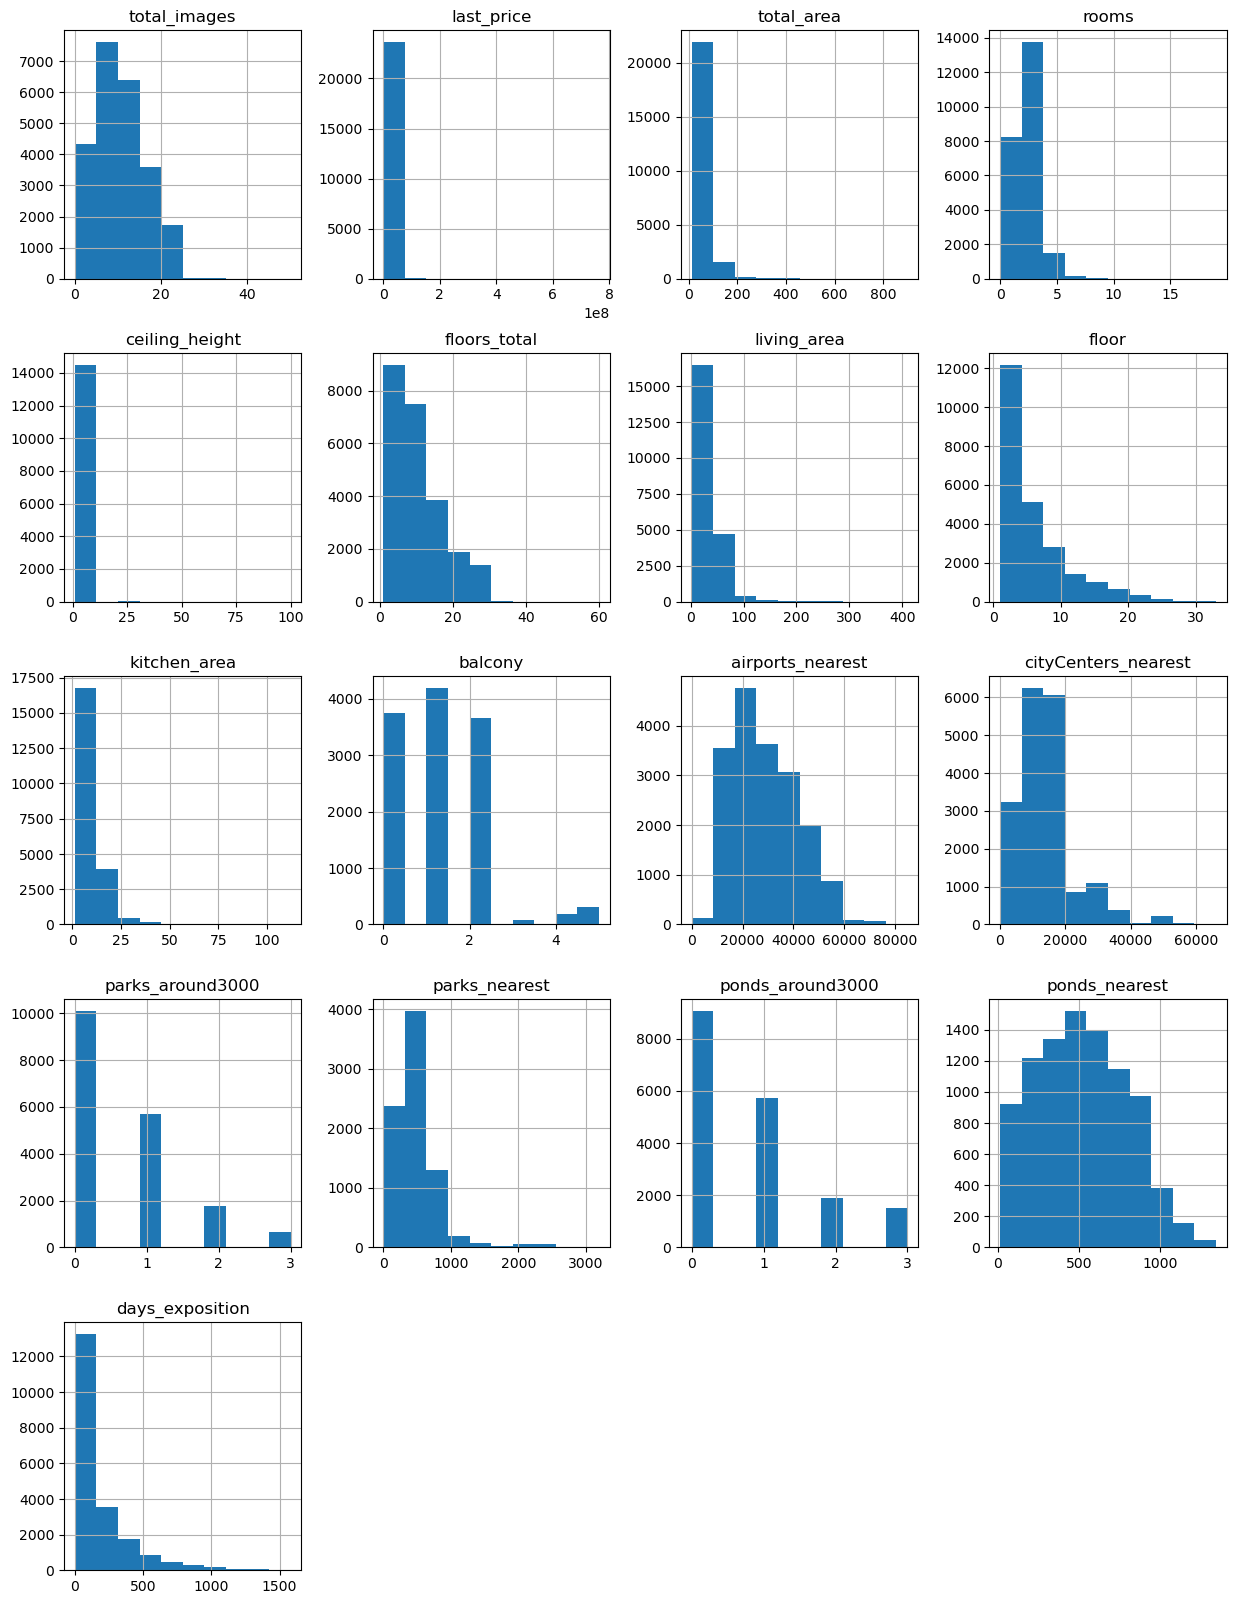

In [4]:
data.hist(figsize=(15, 20))
plt.show()

Видим, что есть столбцы с распределением данных, близким к нормальному, а есть с распределением близким к Пуассоновскому. Так же ряд столбцов содержит аномалии, выбросы и пропуски.

### Предобработка данных

Посчитаем количество пропусков в столбцах:

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Некоторые столбцы не содержат пропусков, в других пропущено свыше 90% данных. Больше всего данных пропущено в картографической информации, такие столбцы будет сложно заполнить корректными значениями, поэтому велика вероятность, что в процессе обработки придется избавиться от большого количества данных, что может существенно исказить результаты исследования. Следует передать разработчикам баг-репорт.

Начнем со стобца, содержащего данные о количестве балконов, предположим, что если продавец не указал количество балконов, то это от того, что их нет. Заменим все пропуски на ноль.

In [7]:
data['balcony'] = data['balcony'].fillna(0)
print(data['balcony'].isna().sum())

0


Для упрощения оценки количества пропусков в столбцах построим столбчатую диаграмму, отсортировав количество пропусков в столбцах по убыванию.

<AxesSubplot:>

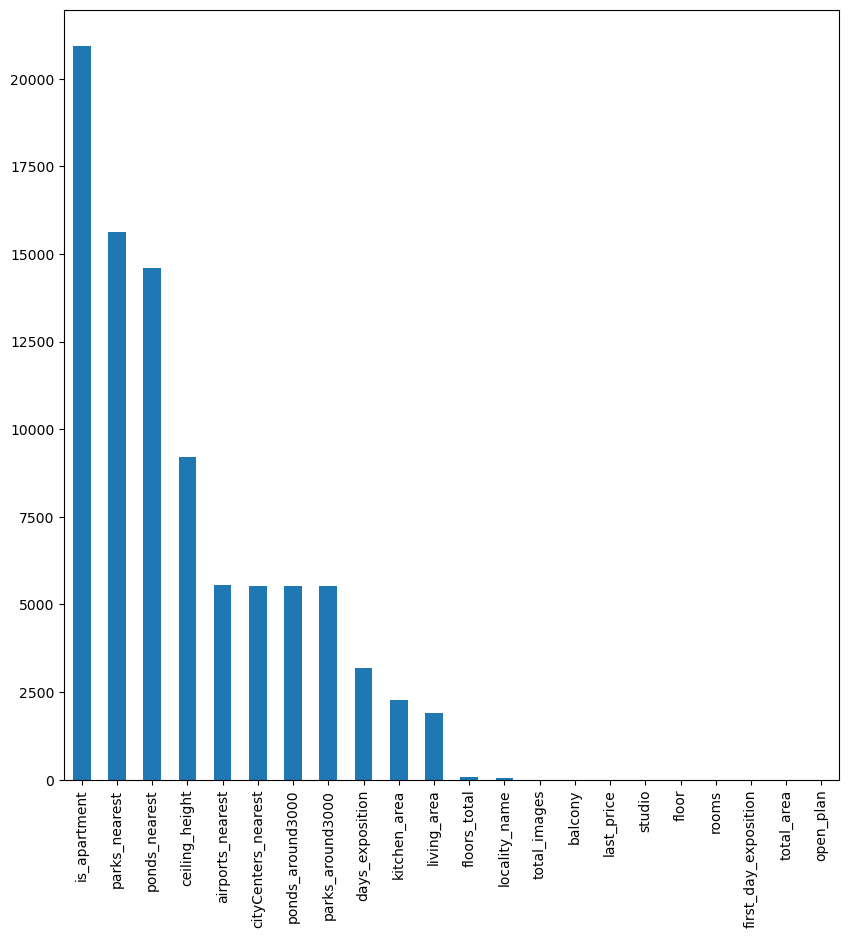

In [8]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', figsize=(10, 10))

#### Промежуточный вывод

Итак, столбец с самым большим количеством пропусков - *is_apartment*, что скорее всего связано с тем, что большая часть продающихся объектов не является аппартаментами, поэтому продавец не заполняет это поле. 
> Большое количество пропусков в столбцах *park_nearest*, *ponds_nearest*, *airoports_nearest*, *cityCenters_nearest*, *ponds_around3000*, *parks_around3000* - невозможно в текущий момент адекватно заполнить какими бы то ни было данными, поэтому их оставим без изменения.  

>В столбцах *floors_total* и *locality_name* проспусков не много, маловероятно, что они дадут статистически значимое искажение данных, поэтому их так же оставим без изменений. Возможно данные не были внесены пользователем, или были утрачены в ходе выгрузки.

> Пропуски в столбцах *ceiling_height*, *kitching_area*, *living_area* и *days_exposition* обработаем. Так же в столбце *first_day_exposition* попробуем привести дату и время к более удобочитаемому виду.
 

**Заполнение пропусков**

Ознакомимся более подробно с данными о столбце *is_apartment*:

In [9]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Из всех заполненных строк только 50 объектов обозначены как апартаменты и 2725 как не апартаменты. Последовательно выведем описание тех и других, для того чтобы понять, есть ли связь между статусом апартаментов и другими характеристиками.

In [10]:
data.query('is_apartment == True').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,50.0000,5.000000e+01,50.000000,50.000000,44.000000,50.000000,42.000000,50.00000,35.000000,50.000000,41.000000,43.000000,43.000000,19.000000,43.000000,30.000000,38.000000
mean,11.1600,1.292420e+07,83.325800,2.080000,6.313864,6.900000,47.979524,4.48000,17.727429,1.280000,33166.463415,14851.000000,0.953488,255.263158,1.232558,534.200000,258.736842
std,5.9637,1.616967e+07,74.015753,1.209486,15.213780,5.218687,49.462974,3.96536,15.749551,1.443352,12961.095675,11138.598302,1.174197,199.620151,1.151339,264.508575,389.759294
min,0.0000,2.150000e+06,20.100000,1.000000,2.500000,2.000000,13.920000,1.00000,5.000000,0.000000,8426.000000,318.000000,0.000000,4.000000,0.000000,22.000000,6.000000
25%,8.0000,4.815750e+06,47.800000,1.000000,2.800000,4.000000,20.422500,2.00000,10.000000,0.000000,24309.000000,5735.000000,0.000000,116.500000,0.000000,322.000000,19.750000
50%,11.0000,6.900000e+06,64.000000,2.000000,3.000000,5.000000,33.250000,3.00000,11.700000,1.000000,31006.000000,13261.000000,0.000000,160.000000,1.000000,569.000000,78.000000
75%,16.0000,1.246768e+07,95.950000,3.000000,3.200000,7.000000,55.700000,5.00000,20.000000,2.000000,44870.000000,20802.000000,2.000000,363.500000,2.500000,792.000000,276.750000
max,20.0000,8.400000e+07,507.000000,7.000000,100.000000,27.000000,301.500000,22.00000,87.200000,5.000000,73391.000000,54490.000000,3.000000,714.000000,3.000000,826.000000,1572.000000


In [11]:
data.query('is_apartment == False').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,2725.000000,2.725000e+03,2725.000000,2725.000000,1818.000000,2725.000000,2613.000000,2725.000000,2550.000000,2725.000000,2103.000000,2104.000000,2104.000000,928.000000,2104.000000,1046.000000,2462.000000
mean,9.230092,6.522225e+06,61.123761,2.086606,2.873812,10.737248,35.026973,5.976147,10.750020,1.004404,28524.539705,14208.418726,0.614068,508.614224,0.795152,502.630019,218.556458
std,5.485756,1.052674e+07,32.063190,1.018471,1.715555,6.542470,19.939367,4.909065,5.708797,1.064365,12450.314240,8924.336308,0.807897,364.804290,0.975864,273.889273,235.341230
min,0.000000,5.500000e+05,13.000000,0.000000,2.000000,1.000000,10.000000,1.000000,2.890000,0.000000,6914.000000,208.000000,0.000000,9.000000,0.000000,16.000000,2.000000
25%,5.000000,3.500000e+06,41.000000,1.000000,2.550000,5.000000,19.000000,2.000000,7.500000,0.000000,18417.000000,9047.000000,0.000000,300.750000,0.000000,276.500000,53.000000
50%,9.000000,4.700000e+06,54.000000,2.000000,2.700000,9.000000,31.000000,5.000000,9.800000,1.000000,26293.000000,12945.000000,0.000000,460.500000,0.000000,485.500000,132.000000
75%,13.000000,6.800000e+06,72.000000,3.000000,2.800000,16.000000,43.000000,8.000000,12.000000,2.000000,36853.000000,16114.000000,1.000000,618.000000,1.000000,710.750000,301.750000
max,21.000000,4.013000e+08,401.000000,9.000000,32.000000,35.000000,204.000000,32.000000,93.200000,5.000000,84665.000000,65764.000000,3.000000,2532.000000,3.000000,1275.000000,1375.000000


array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

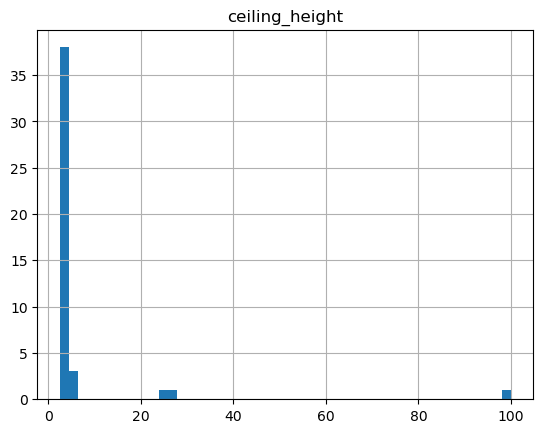

In [12]:
data.query('is_apartment == True').hist('ceiling_height', bins=50)

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

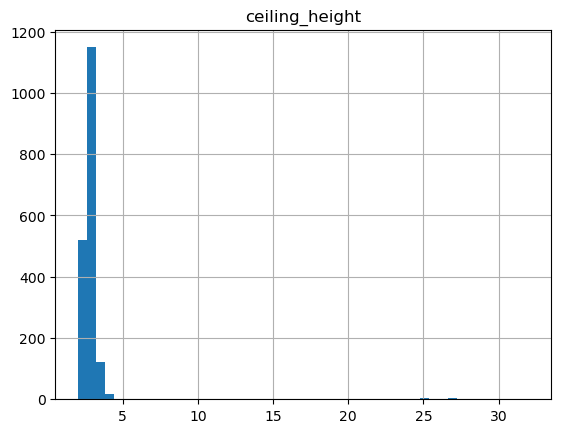

In [13]:
data.query('is_apartment == False').hist('ceiling_height', bins=50)

Самая высокая корреляция обнаружена с высотой потолка, но указывает она скорее на частоту заполнения параметров в данной группе объектов, чем на прямую зависимость одного от другого. С остальными характеристиками корреляция слабая, на основании чего принимается решение заполнить пропуски значением **False**.

In [14]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

**Высота потолков**

Более подробно ознакомимся с содержимым столбца *ceiling_height*:

In [15]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В столбце есть разброс данных от 1 до 100 метров, первое выглядит слишком низким для потолка, второе слишком высоким, и то и другое похоже на ошибку в данных возникшую при заполнении или при переносе данных. Можно привести их к медианным значениям, но сначала оценим наличие пропусков.

In [16]:
display(data['ceiling_height'].isna().sum())
display(data['ceiling_height'].isna().mean())

9195

0.38799105447487237

В столбце отсутсвует 38% данных, что может быть критически важным при оценке их достоверности. Чтобы наиболее точно заполнить пропуски, найдем корреляцию между высотой потолков и другими характеристиками объектов.

In [17]:
correlation = data.corr()
correlation.sort_values('ceiling_height', ascending=False)['ceiling_height'].reset_index().head()

,index,ceiling_height
0,ceiling_height,1.000000
1,is_apartment,0.154959
2,total_area,0.095490
3,living_area,0.090650
4,kitchen_area,0.087641


Корреляцию с типом недвижимости отбрасываем по вышеуказанным причинам, следующая ближайшая характеристика это *total_area*,
однако, связь слабая, коэффициент не составляет и 0,1, поэтому принято решение заполнить пропуски медианным значением столбца.

In [18]:
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceiling_height'] = median
    
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()

for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name']  == locality_name, 'cityCenters_nearest'].median()
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_name'] == locality_name), 'cityCenters_nearest'] = median

In [19]:
display(data['ceiling_height'].isna().sum())

0

**Жилая площадь и площадь кухни**

Столбцы *living_area* и *kitchen_area* на гистограмме расположены рядом, значения их могут быть зависимы друг от друга, а так же от планировки и общей площади. 

In [20]:
corr_kitchen_area = data.corr()
corr_kitchen_area.sort_values('kitchen_area', ascending=False)['kitchen_area'].reset_index().head()

,index,kitchen_area
0,kitchen_area,1.000000
1,total_area,0.609121
2,last_price,0.519869
3,living_area,0.428674
4,rooms,0.269945


In [21]:
corr_living_area = data.corr()
corr_living_area.sort_values('living_area', ascending=False)['living_area'].reset_index().head()

,index,living_area
0,living_area,1.000000
1,total_area,0.939537
2,rooms,0.845977
3,last_price,0.566492
4,kitchen_area,0.428674


In [22]:
display(data['living_area'].isna().sum())
display(data['kitchen_area'].isna().sum())

1903

2278

Выявлена наиболее тесная взаимосвязь исследуемых столбцов со столбцом *total_area*, который не содержит пропусков. При этом
не выявлена связь со столбцом *open_plan*, хотя можно предположить, что в квартирах со свободной планировкой площадь кухни и жилая не выделены. Проверим какое количество пропусков приходится на жилье со свободной планировкой.

In [23]:
display(data[data['living_area'].isna() & data['open_plan']].shape[0])
display(data[data['kitchen_area'].isna() & data['open_plan']].shape[0])
display(data['open_plan'].value_counts())

5

67

False    23632
True        67
Name: open_plan, dtype: int64

По результату проверки видно, что во всех квартирах с открытой планировкой не указана площадь кухни, но при этом жилая площадь не указана только в пяти из этих квартир. Проведем дополнительную проверку. 

In [24]:
data[data['living_area'].isna() & data['kitchen_area'].isna() & (data['rooms'] > 1) & (data['open_plan'] == False)].shape[0]

927

Количество пропусков относительно количества данных в столбце незначительно, заполнить без риска искажения не представляется возможным. Оставляем без изменений.

**Количество дней экспозиции**

In [25]:
display(data['days_exposition'].describe())
display(data['days_exposition'].isna().sum())


count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

3181

Пропуски в столбце могут быть связаны с двумя причинами: во-первых, количество дней экспозиции могут быть меньше одного, во-вторых - экспозиция может быть неокончена, то есть объявление еще не снято с публикации. Первую гипотезу легко проверить.

In [26]:
data[data['days_exposition'] < 1.0].shape[0]

0

Значений меньше одного дня не выявлено, поэтому все объявления с незаполненным столбцом *days_exposition* считаем размещенными на момент выгрузки датасета.

**Расстояние до ближайшего водоема, расстояние до ближайшего парка**

Данные по расстоянию до ближайших рекреационных зон относятся к картографическим и должны были быть просчитаны автоматически, но могут отсутствовать по причине того, что в радиусе поиска таких объектов нет. В этом случае данные можно заменить на ноль, при условии, что в радиусе трех километров таких объектов не находится.


In [27]:
parks_filter = (data['parks_nearest'].isna() 
                    & (data['parks_around3000'].isna() | (data['parks_around3000'] < 1.0)))
data.loc[parks_filter, ['parks_nearest', 'parks_around3000']] = data.loc[parks_filter, ['parks_nearest', 'parks_around3000']].fillna(0)
display(data['parks_nearest'].isna().sum())

0

In [28]:
ponds_filter = (data['ponds_nearest'].isna() 
                & (data['ponds_around3000'].isna() | (data['ponds_around3000'] < 1.0)))
data.loc[ponds_filter, ['ponds_nearest', 'ponds_around3000']] = data.loc[ponds_filter, ['ponds_nearest', 'ponds_around3000']].fillna(0)
display(data['ponds_nearest'].isna().sum())

0

**Вывод**


<AxesSubplot:>

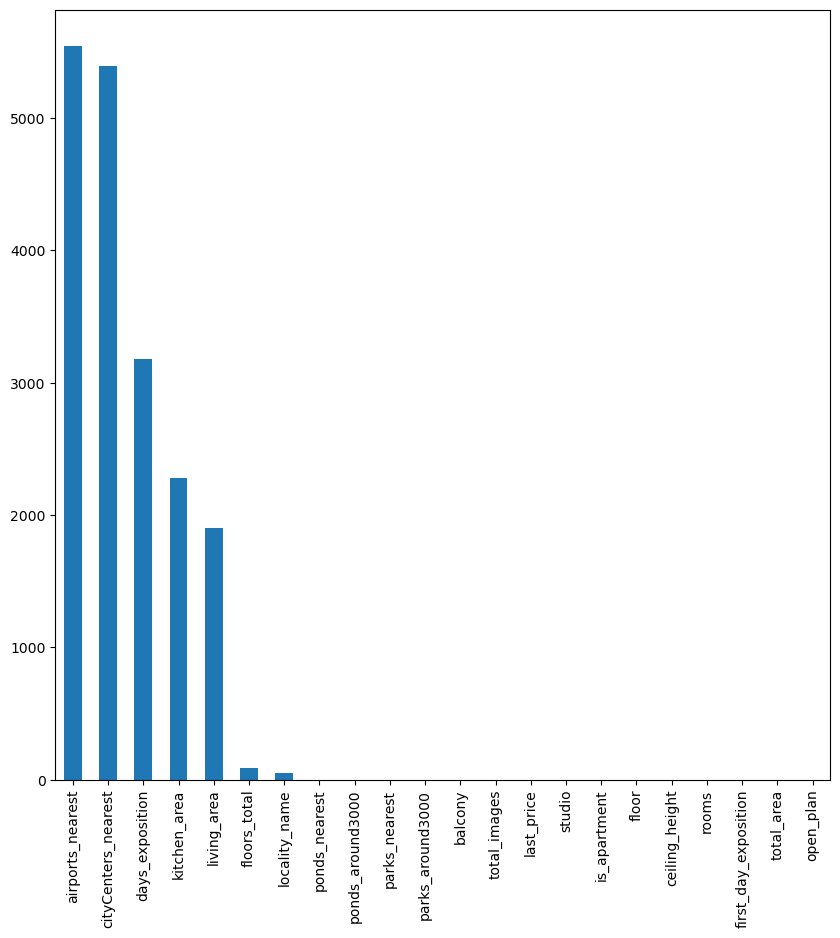

In [29]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', figsize=(10, 10))

In [30]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              86
living_area             1903
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area            2278
balcony                    0
locality_name             49
airports_nearest        5542
cityCenters_nearest     5394
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3181
dtype: int64

Большинство данных обработано, количество пропусков уменьшено. Там где это было допустимо пропущенные значения были заполнены медианными значениями или нулем. Основными причинами пропусков в данных предположительно являлось незаполнение данных пользователями или невозможность их получить, как например в столбцах *airports_nearest* и *cityCenters_nearest*. Так же было принято решение оставить некоторые пропуски без обработки, чтобы избежать искажения данных.

**Изменение типов данных**

In [31]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

In [32]:
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format='%Y-%m-%dT')
display(data['first_day_exposition'])

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

Столбец содержащий информацию о первом дне размещения объявления в качестве времени размещения содержал время и имел тип object.

Заменим в столбцах, значения которых составляют целые числа на int64

In [33]:
data['balcony'] = data['balcony'].astype('int')
data['rooms'] = data['rooms'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')           
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].astype('int')
data['last_price'] = data['last_price'].round()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int32         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [34]:
print(data['last_price'].head())

0    13000000.0
1     3350000.0
2     5196000.0
3    64900000.0
4    10000000.0
Name: last_price, dtype: float64


**Вывод**

Столбец *first_day_exposition* приведен к формату **datatime**, cтолбцы с булевыми значениями не изменялись, столбцы с целочисленными значениями приведены к типу **int64**.

**Обработка дубликатов**

In [35]:
data['locality_name'].value_counts()

Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: locality_name, Length: 364, dtype: int64

In [36]:
data['locality_name'].isna().sum()

49

In [37]:
data['locality_name'] = data['locality_name'].fillna('Unknown')

In [38]:
data['locality_name'].isna().sum()

0

Для столбца *locality_name* выведем частоту значений, количество пропусков. Пропущенные значения заполним значением "неизвестно", т.к. ничем другим их заполнить не представляется возможным.
Далее выведем на экран уникальные значения столбца.

In [39]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Проведем нормализацию данных в столбце, избавимся от типов населенных пунктов, оставив только названия. Приведем все строки к нижнему регистру.

In [40]:
def normalize_names(row):
    value = row['locality_name']
    # left is nan check https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values
    if value != value or value is None:
        return value

    value = value.lower().strip()

    # 'пок'
    words = [
        'садоводческое некоммерческое товарищество', 'посёлок при железнодорожной станции', 'поселок при железнодорожной станции',
        'поселок городского типа', 'посёлок станции', 'поселок станции', 'городской посёлок',
        'посёлок пансионат', 'садовое товарищество',
        'поселок городского типа', 'посёлок городского типа', 'городского типа', 'коттеджный посёлок', 'коттеджный поселок', 'коттеджный',
        'городской', 'посёлок', 'поселок', 'деревня', 'село',
    ]
    for word in words:
        value = value.replace(word, '').strip()

    return value


data['locality_name'] = data.apply(normalize_names, axis=1)

In [41]:
print(len(data['locality_name'].unique()))
print('nan count: ', data['locality_name'].isna().sum())
print(data['locality_name'].unique())

307
nan count:  0
['санкт-петербург' 'шушары' 'янино-1' 'парголово' 'мурино' 'ломоносов'
 'сертолово' 'петергоф' 'пушкин' 'кудрово' 'коммунар' 'колпино'
 'красный бор' 'гатчина' 'фёдоровское' 'выборг' 'кронштадт' 'кировск'
 'новое девяткино' 'металлострой' 'лебяжье' 'сиверский' 'молодцово'
 'кузьмоловский' 'новая ропша' 'павловск' 'пикколово' 'всеволожск'
 'волхов' 'кингисепп' 'приозерск' 'сестрорецк' 'куттузи' 'аннино'
 'ефимовский' 'плодовое' 'заклинье' 'торковичи' 'первомайское' 'красное'
 'понтонный' 'сясьстрой' 'старая' 'лесколово' 'новый свет' 'сланцы'
 'путилово' 'ивангород' 'шлиссельбург' 'никольское' 'зеленогорск'
 'сосновый бор' 'оржицы' 'кальтино' 'романовка' 'бугры' 'рощино' 'кириши'
 'луга' 'волосово' 'отрадное' 'павлово' 'оредеж' 'копорье' 'молодёжное'
 'тихвин' 'победа' 'нурма' 'синявино' 'тосно' 'стрельна' 'бокситогорск'
 'александровская' 'лопухинка' 'пикалёво' 'терволово' 'советский'
 'подпорожье' 'петровское' 'токсово' 'сельцо' 'вырица' 'кипень' 'келози'
 'вартемяги'

In [42]:
print(data['locality_name'].value_counts())

санкт-петербург    15721
мурино               590
кудрово              472
шушары               440
всеволожск           398
                   ...  
мыза-ивановка          1
корнево                1
курковицы              1
шпаньково              1
дзержинского           1
Name: locality_name, Length: 307, dtype: int64


In [43]:
display(data.head(20))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,25.00,0,санкт-петербург,18863.0,16028.0,1,482,2,755,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.63,11.0,18.60,1,False,...,11.00,2,шушары,12817.0,18603.0,0,0,0,0,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.70,5.0,34.30,4,False,...,8.30,0,санкт-петербург,21741.0,13933.0,1,90,2,574,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.70,14.0,NaN,9,False,...,NaN,0,санкт-петербург,28098.0,6800.0,2,84,3,234,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,41.00,0,санкт-петербург,31856.0,8098.0,2,112,1,48,121.0
5,10,2890000.0,30.40,2018-09-10,1,2.60,12.0,14.40,5,False,...,9.10,0,янино-1,NaN,NaN,0,0,0,0,55.0
6,6,3700000.0,37.30,2017-11-02,1,2.64,26.0,10.60,6,False,...,14.40,1,парголово,52996.0,19143.0,0,0,0,0,155.0
7,5,7915000.0,71.60,2019-04-18,2,2.70,24.0,NaN,22,False,...,18.90,2,санкт-петербург,23982.0,11634.0,0,0,0,0,NaN
8,20,2900000.0,33.16,2018-05-23,1,2.70,27.0,15.43,26,False,...,8.81,0,мурино,NaN,NaN,0,0,0,0,189.0
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,6.50,2,санкт-петербург,50898.0,15008.0,0,0,0,0,289.0


Пропуски и неявные дубликаты устранены.

#### Найдите и устраните редкие и выбивающиеся значения

**Поиск аномалий в столбце *last_price*.**

In [44]:
data['last_price'].describe()  

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [45]:
data['last_price'] = data['last_price']/1000000
display(data['last_price'])

0        13.000
1         3.350
2         5.196
3        64.900
4        10.000
          ...  
23694     9.700
23695     3.100
23696     2.500
23697    11.475
23698     1.350
Name: last_price, Length: 23699, dtype: float64

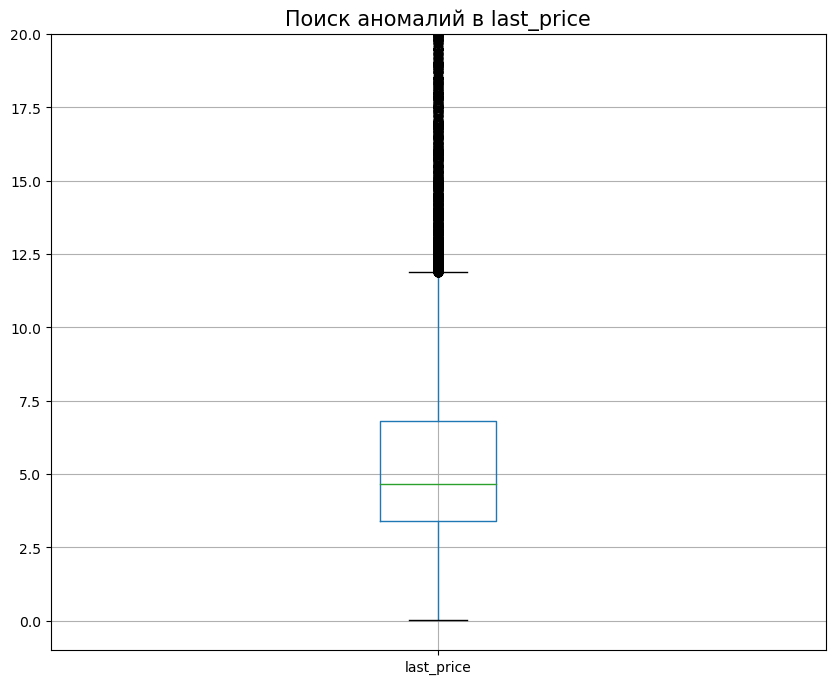

In [46]:
plt.figure(figsize=(10, 8))
data.boxplot(column='last_price')
plt.title('Поиск аномалий в last_price', fontsize=15)
plt.ylim(-1, 20)
plt.show() 

Посмотрим описание данных, отметим минимум и максимум. Далее для удобочитаемости разделим на один млн., сократив тем самым количество нулей. Построим boxplot(). Из графика следует, что средняя цена продажи около шести миллионов рублей. Если опираться на границы усов, то максимальное "хорошее" значение двенадцать миллионов. Остальные можно считать аномальными.  

**Поиск аномалий в столбце *total_area***

In [47]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

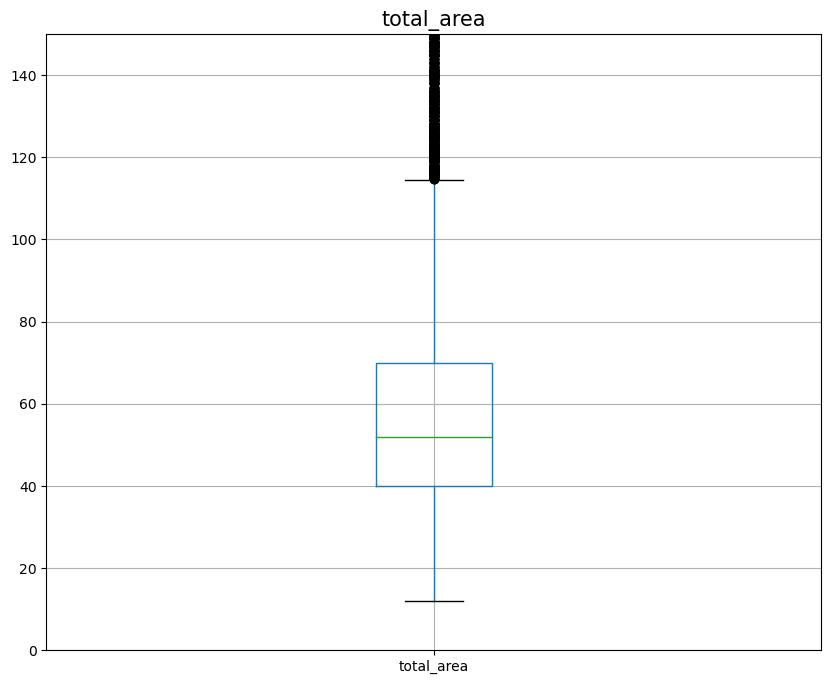

In [48]:
plt.figure(figsize=(10, 8))
data.boxplot(column='total_area')
plt.title('total_area', fontsize=15)
plt.ylim(0, 150)
plt.show()  

В этом столбце выбивающимися можно считать значения общей площади более 115 кв.м.

**Поиск аномалий в столбце living_area**

In [49]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

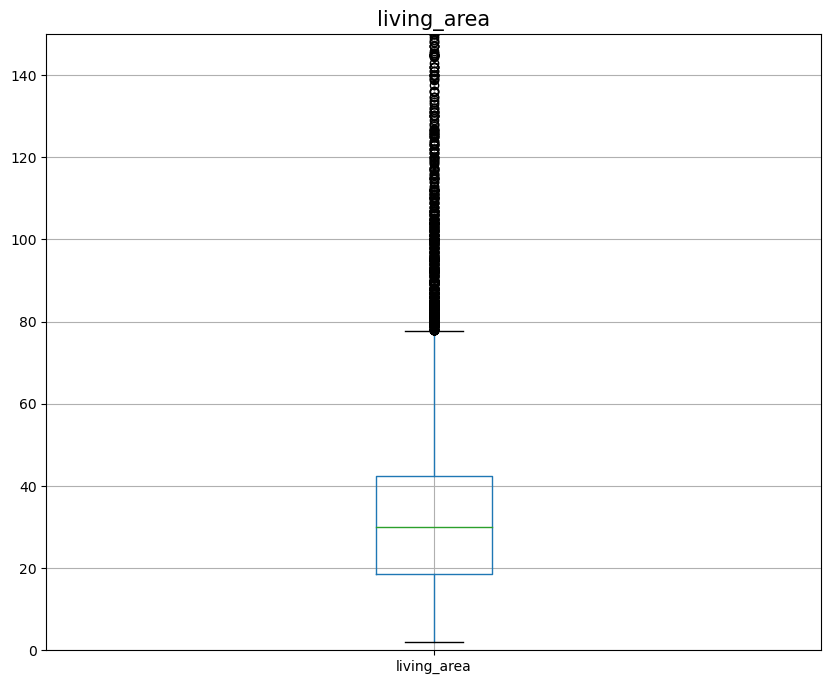

In [50]:
plt.figure(figsize=(10, 8))
data.boxplot(column='living_area')
plt.title('living_area', fontsize=15)
plt.ylim(0, 150)
plt.show()

Для столбца со значениями жилая площадь есть множество единичных значений от 78 кв.м. Это достаточно большое количество данных, поэтому посмотрим как значения этого столбца коррелируют со столбцом *total_area*.

In [51]:
corr = data[[
           'total_area',\
           'living_area'    
               ]].corr()
corr.style.background_gradient(cmap='Greys')

,total_area,living_area
total_area,1.000000,0.939537
living_area,0.939537,1.000000


Коэффициент корреляции близкий к единице, что говорит нам о том, что действительно в наборе данных больше количество квартир имеют метраж больше среднего.

**Поиск аномалий в столбце *rooms***

In [52]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

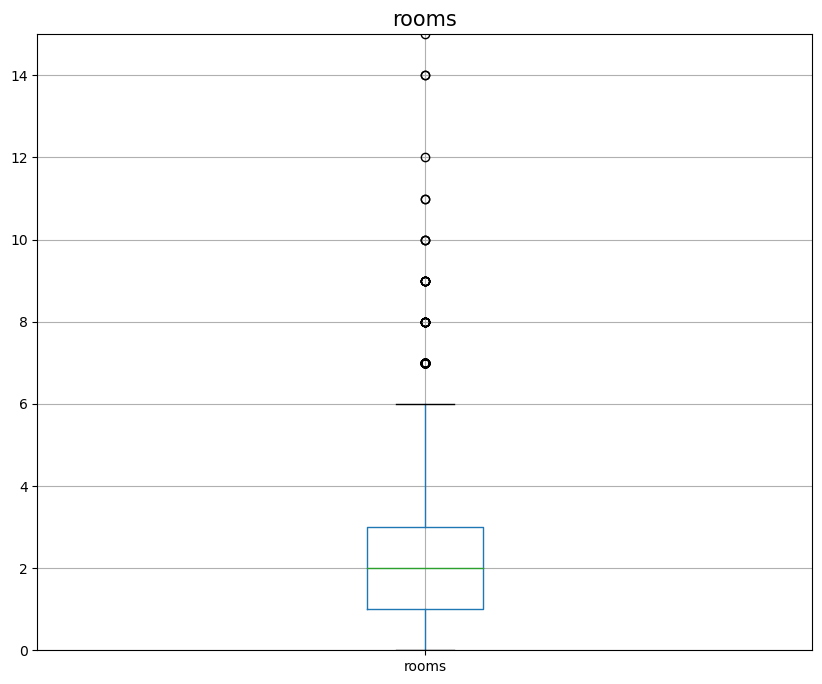

In [53]:
plt.figure(figsize=(10, 8))
data.boxplot(column='rooms')
plt.title('rooms', fontsize=15)
plt.ylim(0, 15)
plt.show()

В столбце с указанием количества комнат представлены данные о квартирах в среднем имеющих от 1 до 3 комнат, но размах сообщает о том, есть 4-5 и 6 комнатные квартиры. С учетом специфической застройки города Санкт-Петербура, можно предположить там и наличие 8-10 конатных квартир. Однако значения в 12, 14 и 19 комнат лучше считать аномальными.

**Поиск аномалий в столбце *ceiling_height***

In [54]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.733877
std          1.009388
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

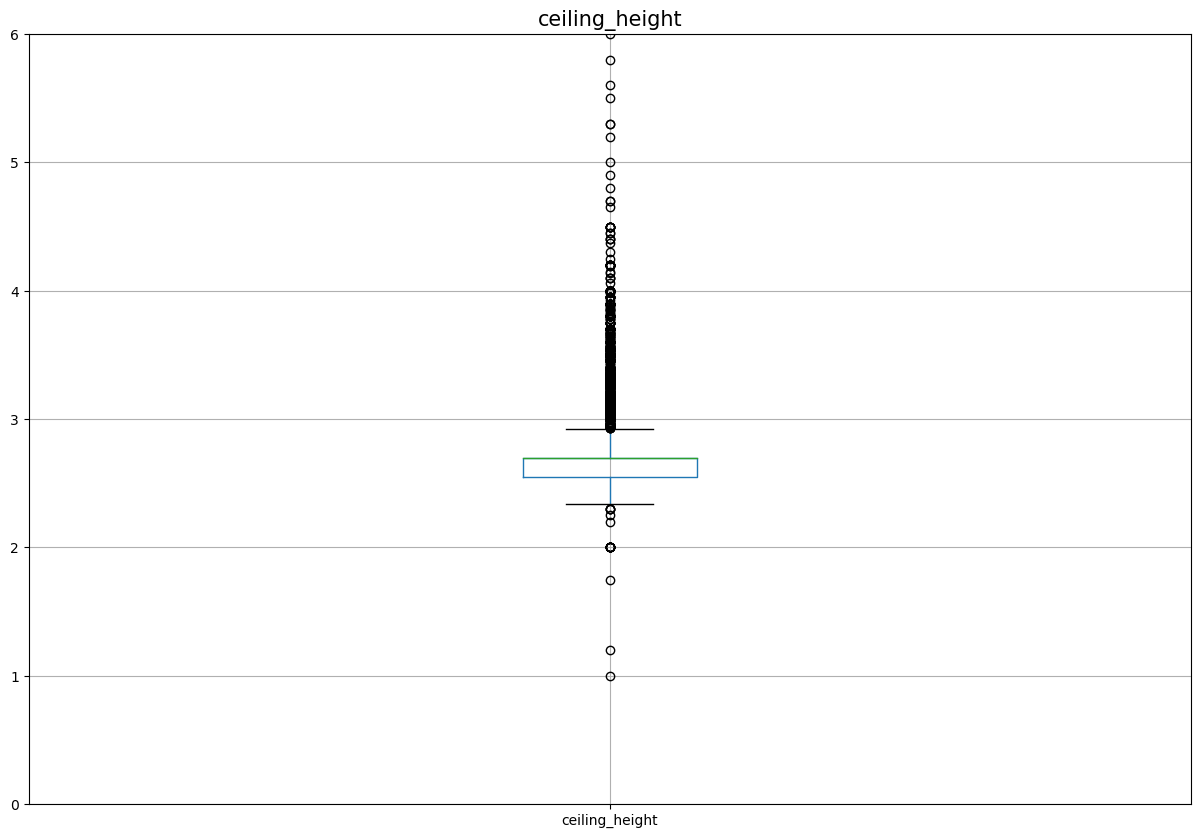

In [55]:
plt.figure(figsize=(15, 10))
data.boxplot(column='ceiling_height')
plt.title('ceiling_height', fontsize=15)
plt.ylim(0, 6)
plt.show()

В столбце с высотой потолков есть не только аномально высокие, но и аномально низкие значения, ниже 2,4 метра и даже потолок высотой в один метр. Скорее всего данные в этом случае были внесены неверно.

**Поиск аномалий в столбце *floors_total***

In [56]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

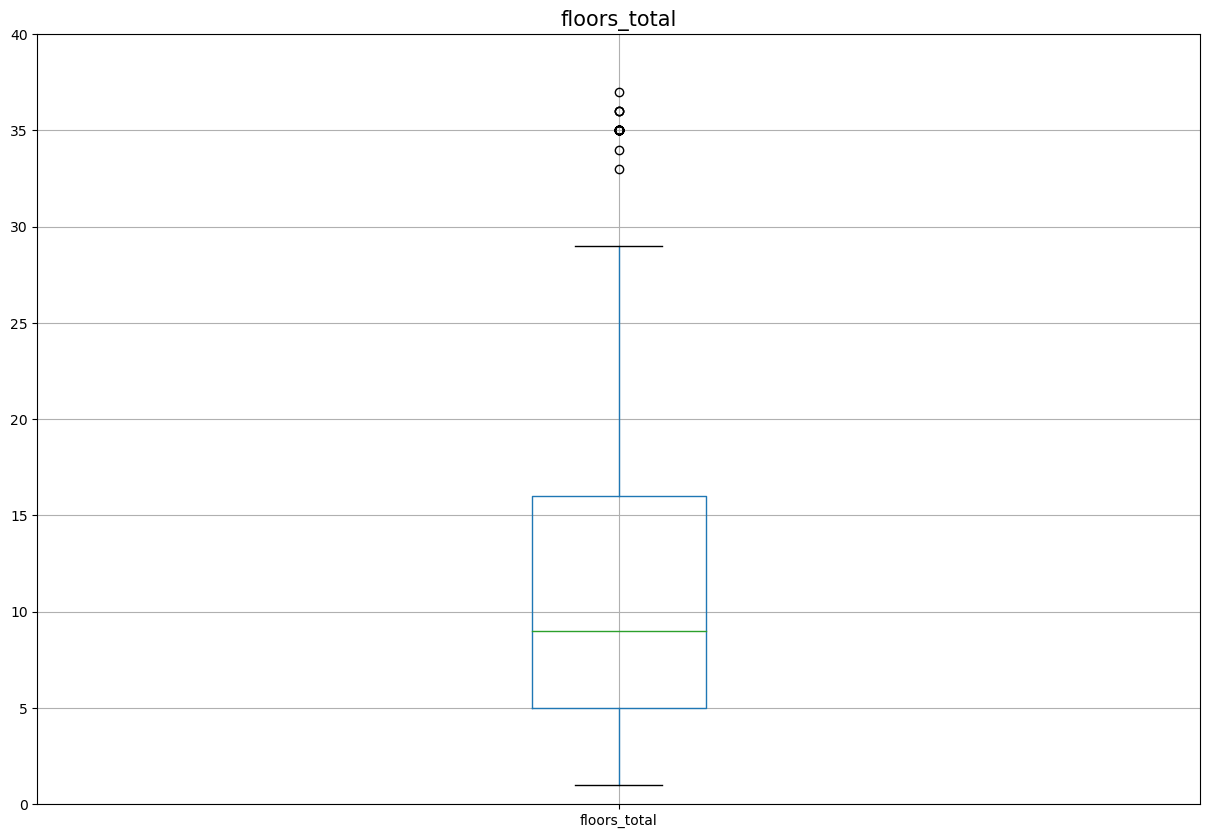

In [57]:
plt.figure(figsize=(15, 10))
data.boxplot(column='floors_total')
plt.title('floors_total', fontsize=15)
plt.ylim(0, 40)
plt.show()

В столбце есть аномальные значения, а в среднем квартиры продаются с первого по двадцать восьмой этаж.

**Поиск аномалий в столбце *days_exposition***

In [58]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

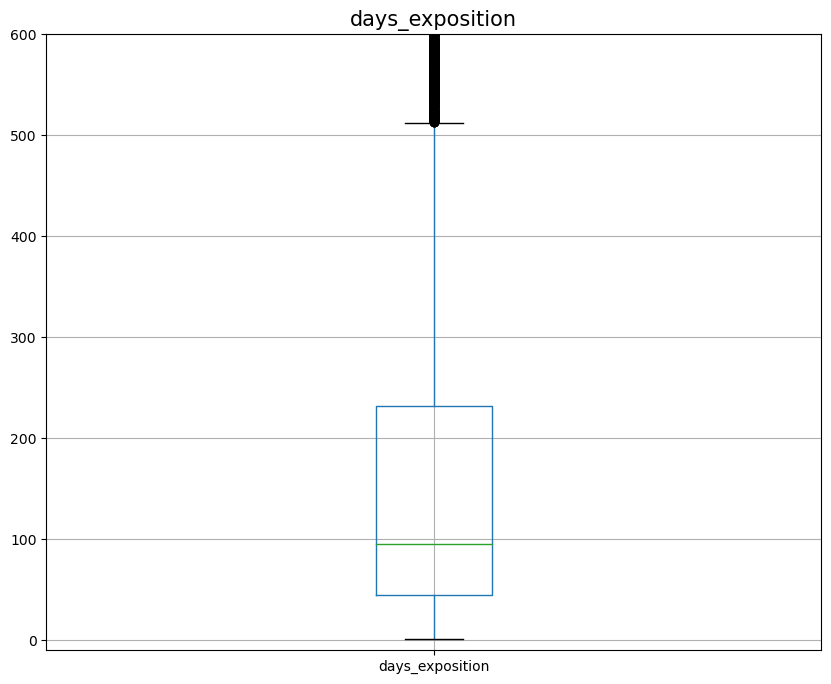

In [59]:
plt.figure(figsize=(10, 8))
data.boxplot(column='days_exposition')
plt.title('days_exposition', fontsize=15)
plt.ylim(-10, 600)
plt.show()

По диаграмме размаха, мы видим, что объявлений со сроком размещения ниже нуля нет. Средний диапазон продажи квартиры составляет менее ста дней. Однако верхний "ус" показывает, что есть значительная часть объявлений, которая экспонируется до 500 дней и больше.

**Промежуточный вывод**

В среднем квартира площадью 60 кв.м., со средней жилой площадью 34 кв.м., состоящая из 2 комнат, с высотой потолка 2,7 метра, продается за 180 дней, при средней цене продажи 6,5 млн. руб.

Все перечисленные критерии были визуализированы с помощью диаграммы размаха, выбивающиеся значения определялись с опорой на коробку и усы графиков.

In [60]:
data['ceiling_height'].unique()

array([  2.7  ,   2.63 ,   3.03 ,   2.6  ,   2.64 ,   2.5  ,   2.67 ,
         2.55 ,   2.56 ,   3.05 ,   2.75 ,   2.9  ,   2.56 ,   2.8  ,
         3.   ,   2.65 ,   3.2  ,   2.61 ,   3.25 ,   3.45 ,   2.77 ,
         2.85 ,   2.525,   2.57 ,   4.15 ,   3.5  ,   3.3  ,   2.71 ,
         4.   ,   2.47 ,   2.73 ,   2.84 ,   3.1  ,   2.34 ,   3.4  ,
         2.52 ,   3.06 ,   2.72 ,   2.54 ,   2.51 ,   2.78 ,  13.85 ,
         2.76 ,  25.   ,   2.58 ,   3.7  ,   5.2  ,   2.87 ,   2.66 ,
         2.59 ,   2.   ,   2.45 ,   3.6  ,   3.9  ,   2.92 ,   3.11 ,
         3.13 ,   3.8  ,   3.15 ,   3.55 ,   3.16 ,   3.62 ,   3.12 ,
         2.53 ,   2.74 ,   2.96 ,   2.46 ,   5.3  ,   5.   ,   2.79 ,
         2.95 ,   4.06 ,   2.94 ,   3.82 ,   3.54 ,   3.53 ,   2.83 ,
         4.7  ,   2.4  ,   3.38 ,   3.01 ,   5.6  ,   3.65 ,   3.18 ,
         3.35 ,   2.3  ,   3.57 ,   2.48 ,   2.515,   2.62 ,   2.82 ,
         2.65 ,   3.98 ,   3.83 ,  27.   ,   3.52 ,   3.95 ,   3.75 ,
         2.88 ,   3.

In [61]:
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] = data['ceiling_height']*0.10

display(data['ceiling_height'].unique())

array([ 2.7  ,  2.63 ,  3.03 ,  2.6  ,  2.64 ,  2.5  ,  2.67 ,  2.55 ,
        2.56 ,  3.05 ,  2.75 ,  2.9  ,  2.56 ,  2.8  ,  3.   ,  2.65 ,
        3.2  ,  2.61 ,  3.25 ,  3.45 ,  2.77 ,  2.85 ,  2.525,  2.57 ,
        4.15 ,  3.5  ,  3.3  ,  2.71 ,  4.   ,  2.47 ,  2.73 ,  2.84 ,
        3.1  ,  2.34 ,  3.4  ,  2.52 ,  3.06 ,  2.72 ,  2.54 ,  2.51 ,
        2.78 , 13.85 ,  2.76 ,  2.58 ,  3.7  ,  5.2  ,  2.87 ,  2.66 ,
        2.59 ,  2.   ,  2.45 ,  3.6  ,  3.9  ,  2.92 ,  3.11 ,  3.13 ,
        3.8  ,  3.15 ,  3.55 ,  3.16 ,  3.62 ,  3.12 ,  2.53 ,  2.74 ,
        2.96 ,  2.46 ,  5.3  ,  5.   ,  2.79 ,  2.95 ,  4.06 ,  2.94 ,
        3.82 ,  3.54 ,  3.53 ,  2.83 ,  4.7  ,  2.4  ,  3.38 ,  3.01 ,
        5.6  ,  3.65 ,  3.18 ,  3.35 ,  2.3  ,  3.57 ,  2.48 ,  2.515,
        2.62 ,  2.82 ,  2.65 ,  3.98 ,  3.83 ,  3.52 ,  3.95 ,  3.75 ,
        2.88 ,  3.67 ,  3.87 ,  3.66 ,  3.85 ,  3.86 ,  4.19 ,  3.24 ,
        4.8  ,  4.5  ,  4.2  ,  3.36 ,  3.08 ,  3.68 ,  3.07 ,  3.37 ,
      

In [62]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.707974
std          0.307292
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max         20.000000
Name: ceiling_height, dtype: float64

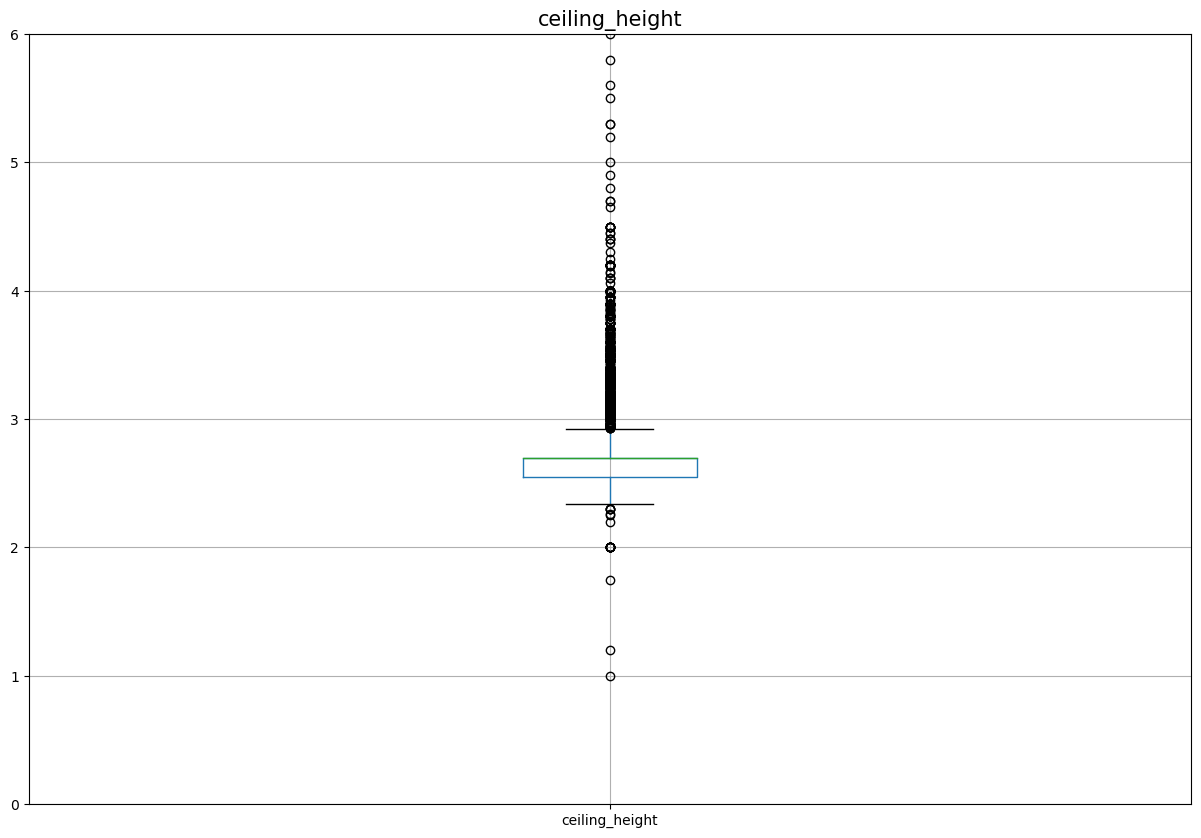

In [63]:
plt.figure(figsize=(15, 10))
data.boxplot(column='ceiling_height')
plt.title('ceiling_height', fontsize=15)
plt.ylim(0, 6)
plt.show()

In [64]:
data.duplicated().sum()

0

Явных дубликатов в данных не выявлено.

#### Вывод

Были произведены изучение и предварительная обработка данных.
Посчитаны и заполнены пропуски в данных, надены и устранены явные и неявные дубликаты, данные приведены к заданным типам. Обнаружены и изучены аномалии данных.

### Посчитайте и добавьте в таблицу новые столбцы

**Цена одного квадратного метра**


Для вычисления стоимости квадратного метра разделим цену продажи на общую площадь. Тип данных приведем к int64, т.к. в данной ситуации точности "до рубля" достаточно.

In [65]:
data['square_meter_price'] = data['last_price'] / data['total_area']
data['square_meter_price']=data['square_meter_price'].astype(int)
display(data['square_meter_price'])

0        0
1        0
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    0
23698    0
Name: square_meter_price, Length: 23699, dtype: int32

**День недели публикации объявления**

In [66]:
data['day'] = pd.DatetimeIndex(data['first_day_exposition']).dayofweek
print(data['day'])

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: day, Length: 23699, dtype: int64


**Месяц публикации объявления**

In [67]:
import numpy as np

In [68]:
data['month'] = data['first_day_exposition'].astype('datetime64[M]')
print(data['month'])

0       2019-03-01
1       2018-12-01
2       2015-08-01
3       2015-07-01
4       2018-06-01
           ...    
23694   2017-03-01
23695   2018-01-01
23696   2018-02-01
23697   2017-03-01
23698   2017-07-01
Name: month, Length: 23699, dtype: datetime64[ns]


**Год публикации объявления**

In [69]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
print(data['year'])

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: year, Length: 23699, dtype: int64


**Тип этажа квартиры (значения — «первый», «последний», «другой»)**

Вернемся к столбцам *floors* и *floors_total*, чтобы провести категоризаю данных и записать столбец *floor_category* в датафрейм.

In [70]:
display(data['floor'].describe())
display(data['floor'].isna().sum())

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

0

Cтолбец не содержит пропусков и имеет минимальное значение 1 и максимальное 33.

In [71]:
display(data['floors_total'].describe())
display(data['floors_total'].isna().sum())

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

86

Столбец содержит пропуски, будем это учитывать при построении функции и опираясь на показатель среднего выборки отнесем их к категории "другой".

In [72]:
def categorize_floor(row):
    floor = row['floor']
    total = row['floors_total']
    if floor == 1:
        return 'первый'
    if  floor == total:
        return 'последний'
    else:
        return 'другой'
data['floor_category'] = data.apply(categorize_floor, axis=1)

In [73]:
print(data['floor_category'].unique())
display(data.head(5))

['другой' 'первый' 'последний']


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day,month,year,floor_category
0,20,13.000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,1,482,2,755,NaN,0,3,2019-03-01,2019,другой
1,7,3.350,40.4,2018-12-04,1,2.63,11.0,18.6,1,False,...,0,0,0,0,81.0,0,1,2018-12-01,2018,первый
2,10,5.196,56.0,2015-08-20,2,2.70,5.0,34.3,4,False,...,1,90,2,574,558.0,0,3,2015-08-01,2015,другой
3,0,64.900,159.0,2015-07-24,3,2.70,14.0,NaN,9,False,...,2,84,3,234,424.0,0,4,2015-07-01,2015,другой
4,2,10.000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,2,112,1,48,121.0,0,1,2018-06-01,2018,другой


**Расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)**

In [74]:
data['cityCenters_nearest'].describe()

count    18305.000000
mean     14231.683201
std       8625.989235
min        181.000000
25%       9274.000000
50%      13101.000000
75%      16326.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [75]:
data['cityCenters_km'] = (data['cityCenters_nearest']/1000)
display(data['cityCenters_km'].isna().sum())

5394

In [76]:
data['cityCenters_km'] = data['cityCenters_km'].fillna(0)

In [77]:
data['cityCenters_km'] = round(data['cityCenters_km'], 0)

In [78]:
display(data['cityCenters_km'].head(15))

0     16.0
1     19.0
2     14.0
3      7.0
4      8.0
5      0.0
6     19.0
7     12.0
8      0.0
9     15.0
10    14.0
11    52.0
12     0.0
13    33.0
14    31.0
Name: cityCenters_km, dtype: float64

Пропуски в столбце составляют более 25% от общего количества данных, заменить их медианными или средними значениями не представляется возможным, ввиду наличия большого количества разных типов населенных пунктов, включая те, которые в принципе могут не иметь какого-то ярко выраженного центра. Принято решение заполнить все пропуски нулем. Метры переведены в километры путем арифметической операции. Значения округлены до целых.

In [79]:
display(data.head(5))
display(data['cityCenters_nearest'].head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day,month,year,floor_category,cityCenters_km
0,20,13.000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482,2,755,NaN,0,3,2019-03-01,2019,другой,16.0
1,7,3.350,40.4,2018-12-04,1,2.63,11.0,18.6,1,False,...,0,0,0,81.0,0,1,2018-12-01,2018,первый,19.0
2,10,5.196,56.0,2015-08-20,2,2.70,5.0,34.3,4,False,...,90,2,574,558.0,0,3,2015-08-01,2015,другой,14.0
3,0,64.900,159.0,2015-07-24,3,2.70,14.0,NaN,9,False,...,84,3,234,424.0,0,4,2015-07-01,2015,другой,7.0
4,2,10.000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112,1,48,121.0,0,1,2018-06-01,2018,другой,8.0


0    16028.0
1    18603.0
2    13933.0
3     6800.0
4     8098.0
Name: cityCenters_nearest, dtype: float64

### Проведите исследовательский анализ данных

#### Общая площадь

In [80]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

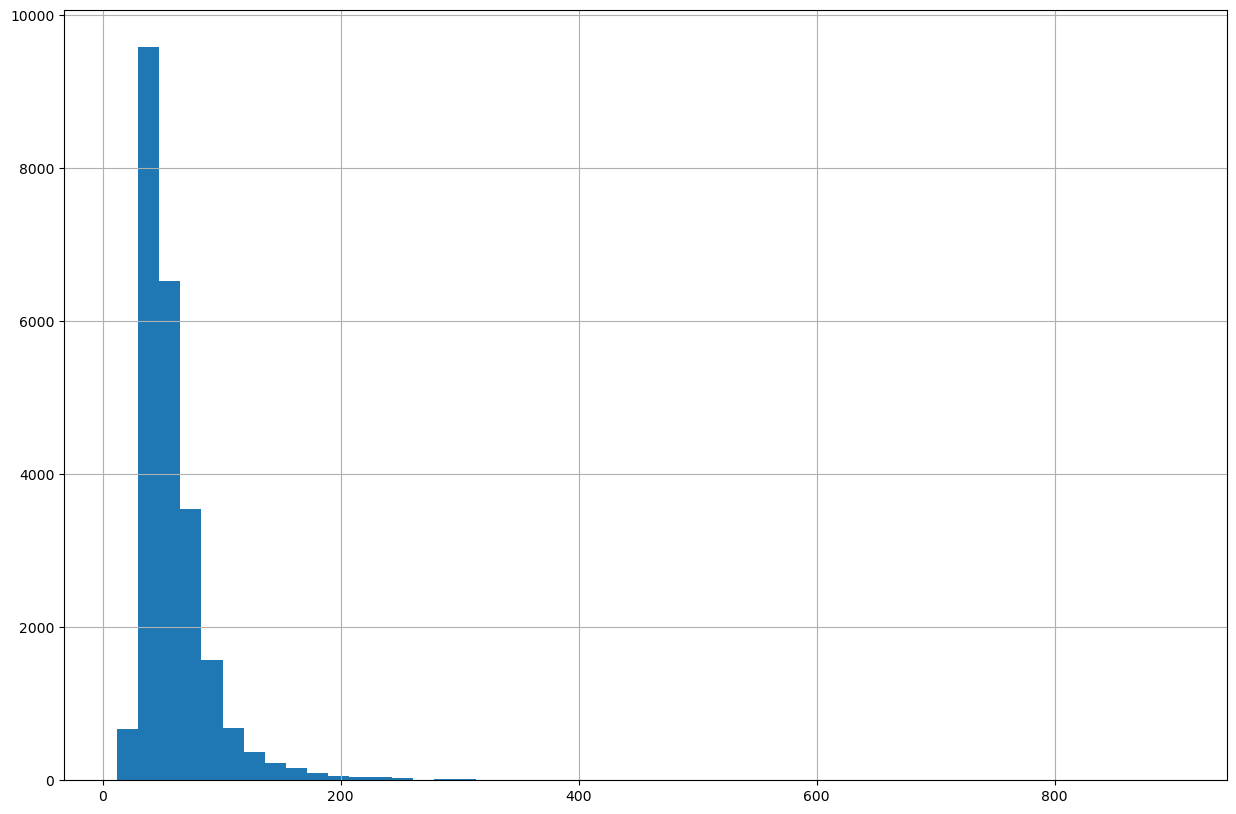

In [81]:
data['total_area'].hist(bins=50, figsize=(15, 10))

Изучим описание столбца и построим гистограмму. По гистограмме видно, что большая часть квартир имеет площадь до двухсот метров. Однако, по описанию столбца мы можем обратить внимание на то, что максимальная площадь достигает 900 метров. Построим отдельные гистограммы, чтобы посмотреть как распределяются значения.

<AxesSubplot:>

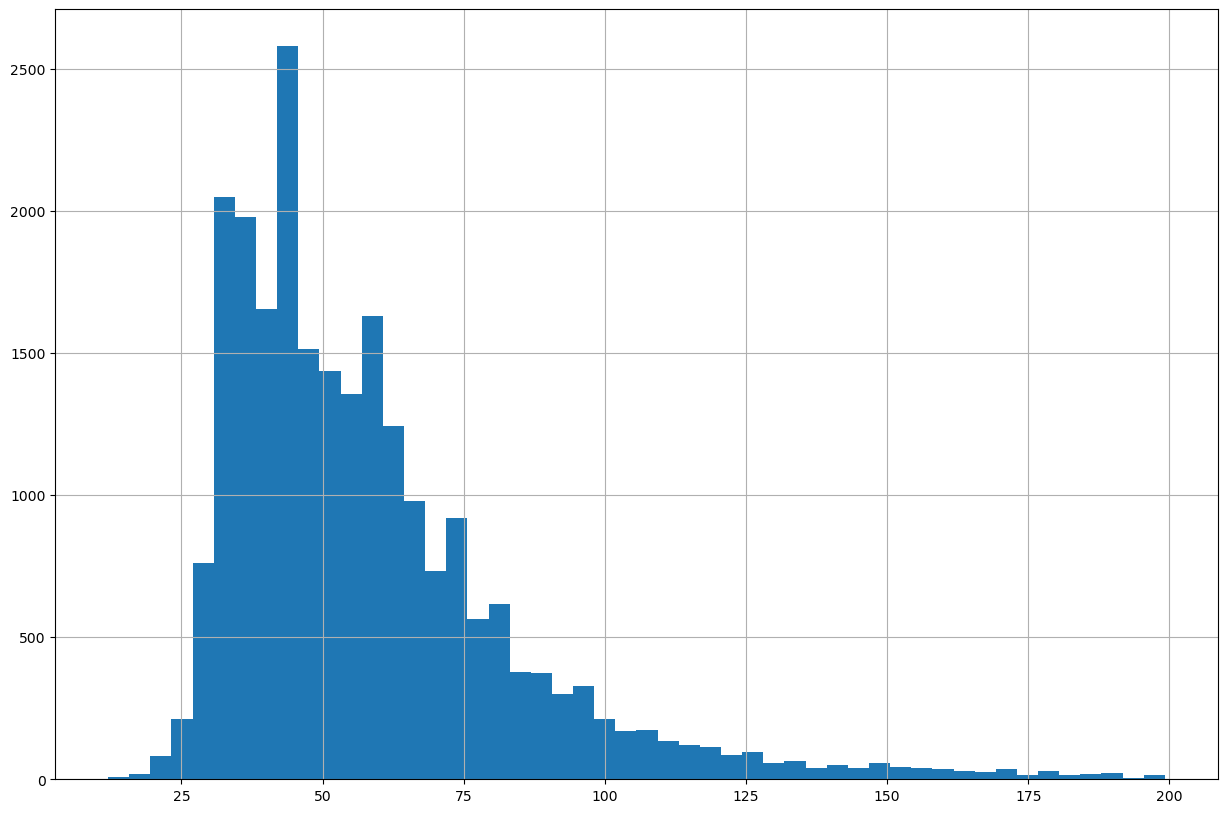

In [82]:
data.query('total_area < 200')['total_area'].hist(bins=50, figsize=(15, 10))

<AxesSubplot:>

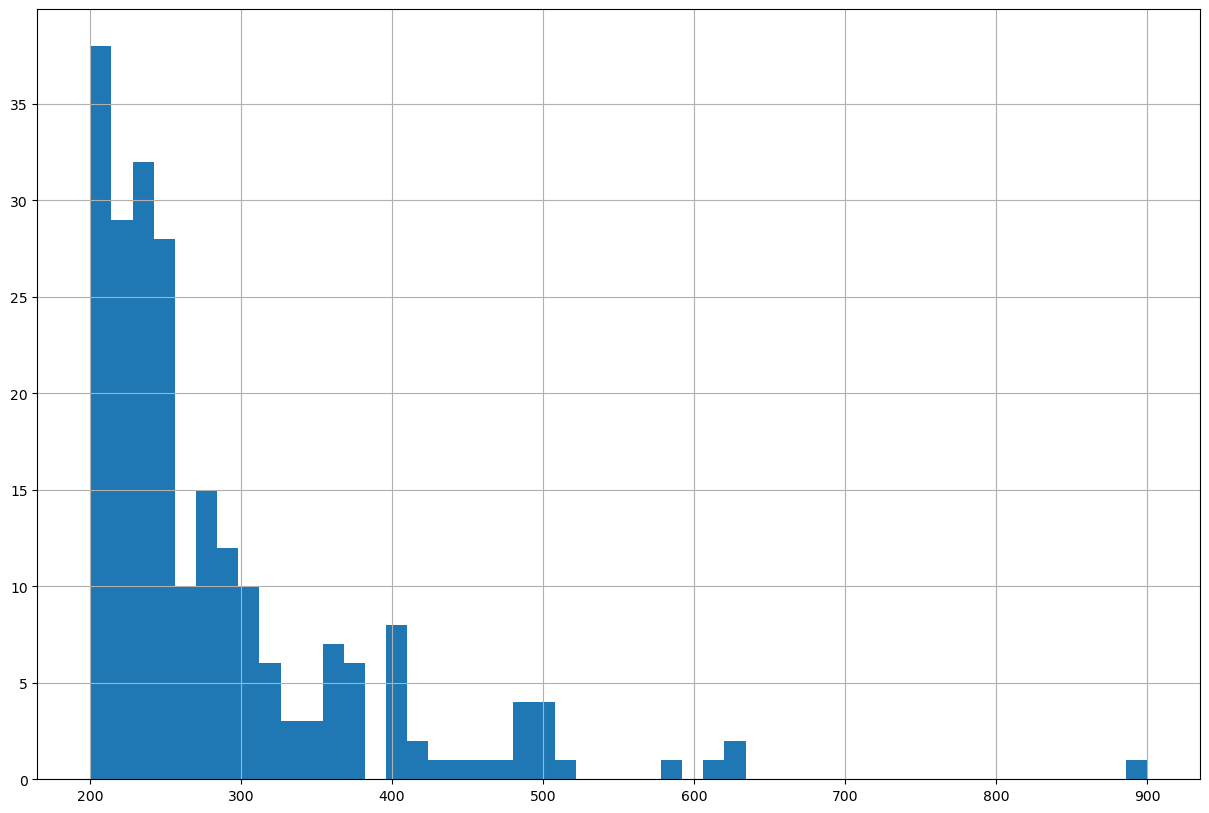

In [83]:
data.query('total_area > 200')['total_area'].hist(bins=50, figsize=(15, 10))

На гистограммах видно, что большая часть квартир имеет площадь от 25 до 60 кв.м. Значения больше 500 кв.м единичные и могут расцениваться, как выбросы.

**Жилая площадь**

In [84]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<AxesSubplot:>

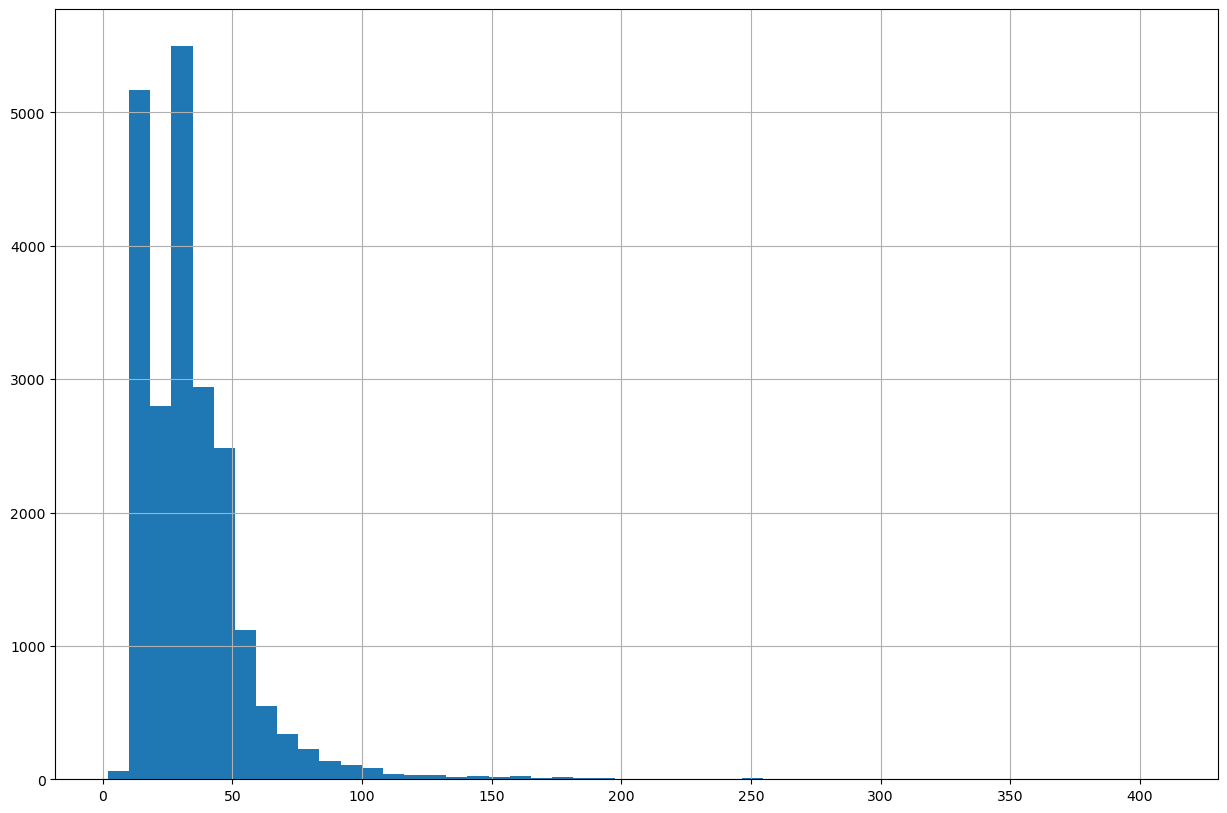

In [85]:
data['living_area'].hist(bins=50, figsize=(15,10))

Большинство квартир на гистограмме имеет жилую площадь от 2 до 50 кв.м., но встречаются и большие площади. Визуализируем их отдельно.

<AxesSubplot:>

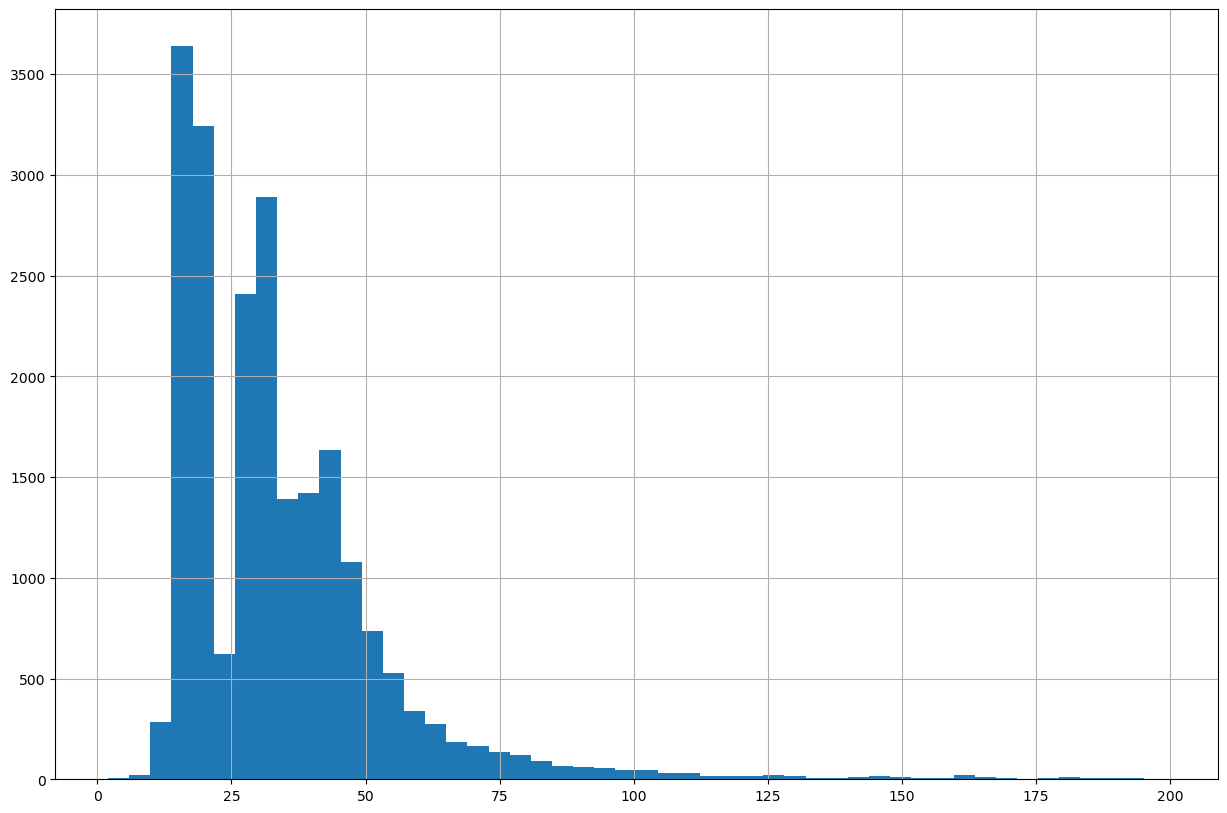

In [86]:
data.query('living_area < 200')['living_area'].hist(bins=50, figsize=(15, 10))

<AxesSubplot:>

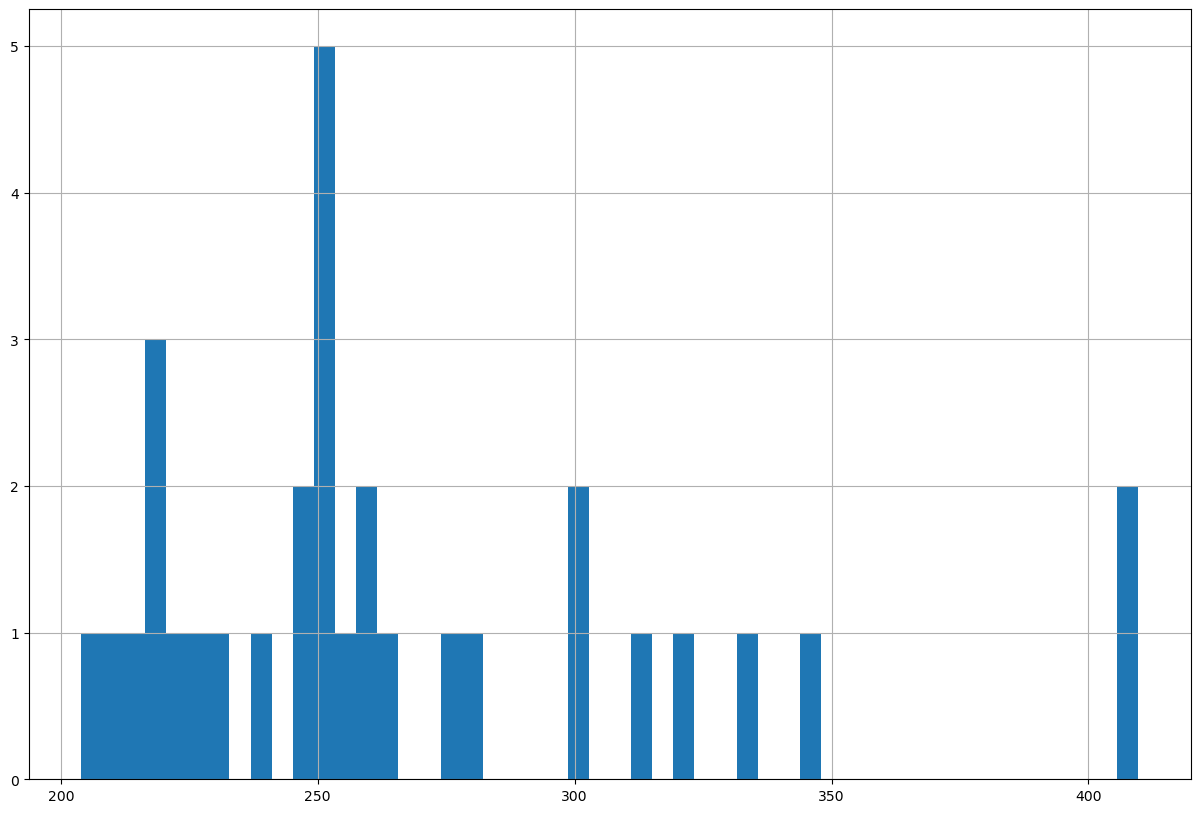

In [87]:
data.query('living_area > 200')['living_area'].hist(bins=50, figsize=(15, 10))

В целом распределение похоже на распределение общей площади, что подтверждает гипотезу о корреляции размера жилой площади, с размером общей площади квартиры.

**Площадь кухни**

In [88]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

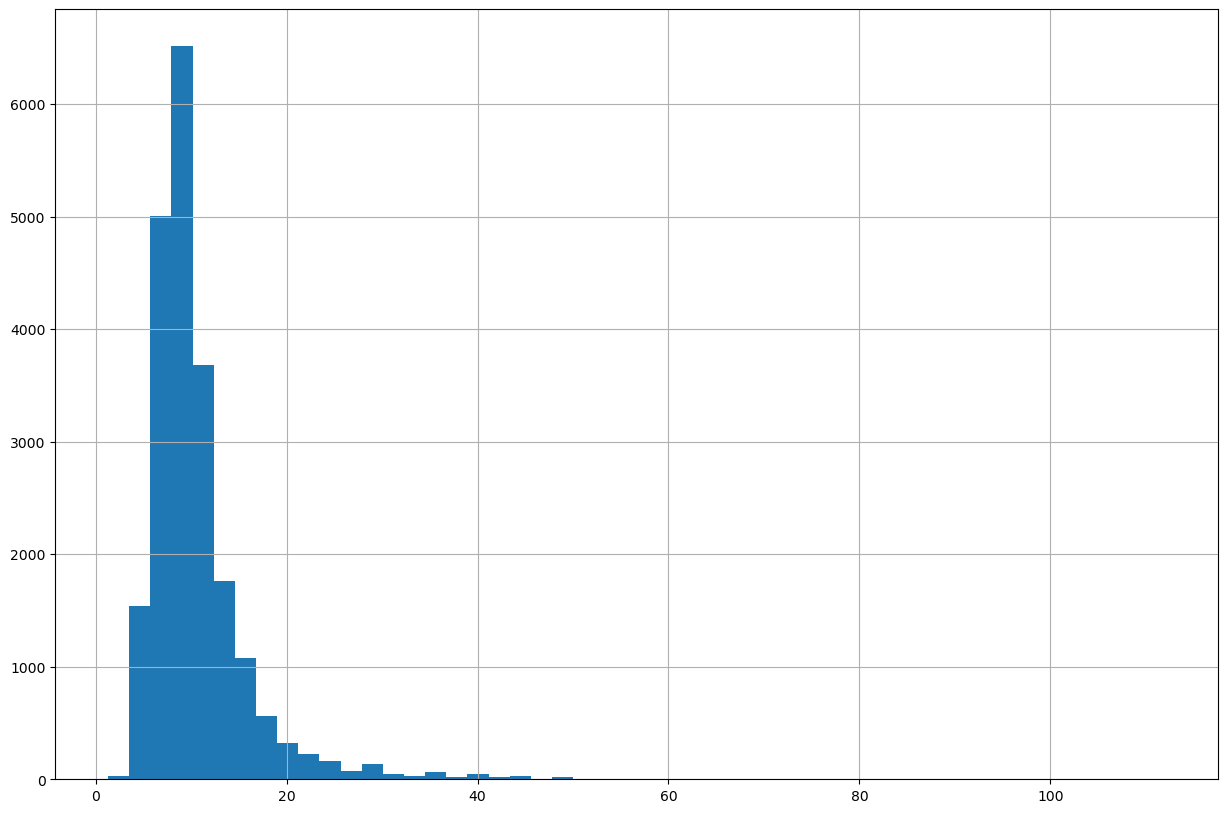

In [89]:
data['kitchen_area'].hist(bins=50, figsize=(15,10))

<AxesSubplot:>

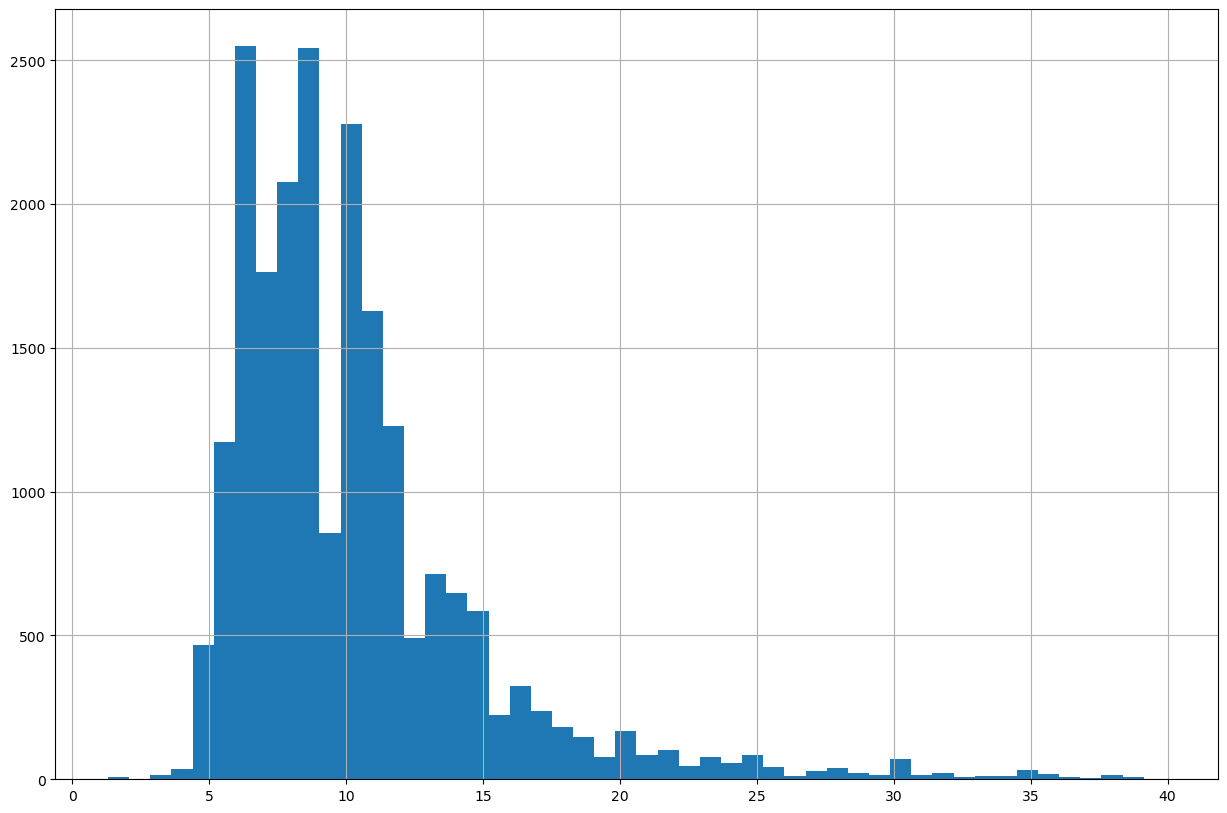

In [90]:
data.query('kitchen_area < 40')['kitchen_area'].hist(bins=50, figsize=(15,10))

<AxesSubplot:>

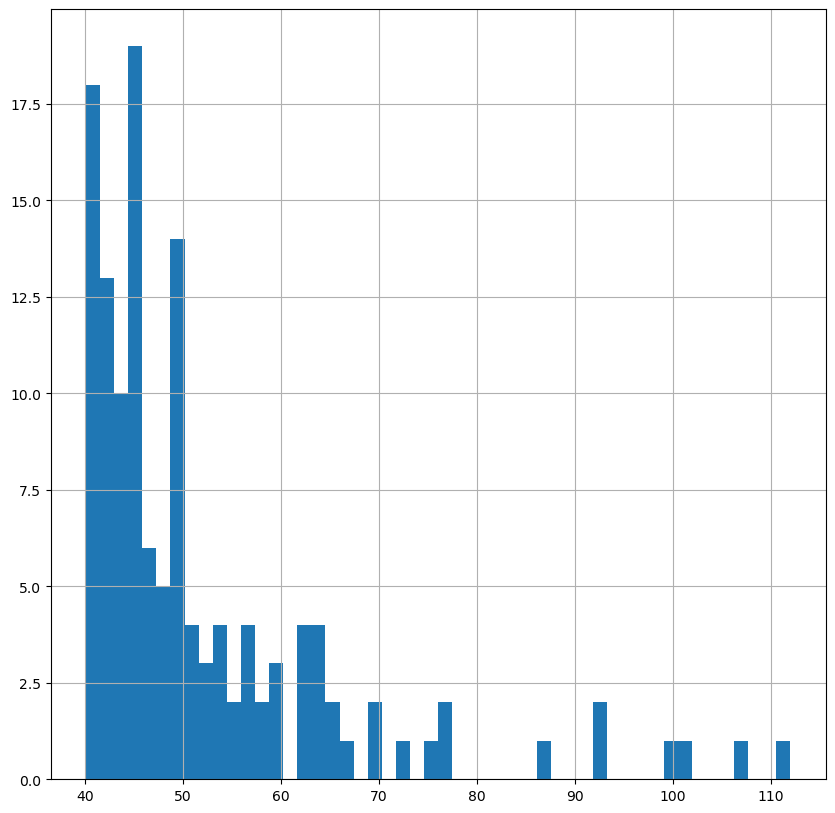

In [91]:
data.query('kitchen_area > 40')['kitchen_area'].hist(bins=50, figsize=(10,10))

Площадь кухни в основной массе имеет площадь от 5 до 15 кв.м., но есть и высокие значения, которые перекликаются с повышенными значениями общей площади и жилой площади.

**Цена объекта**

In [92]:
data['last_price'].describe()

count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

<AxesSubplot:>

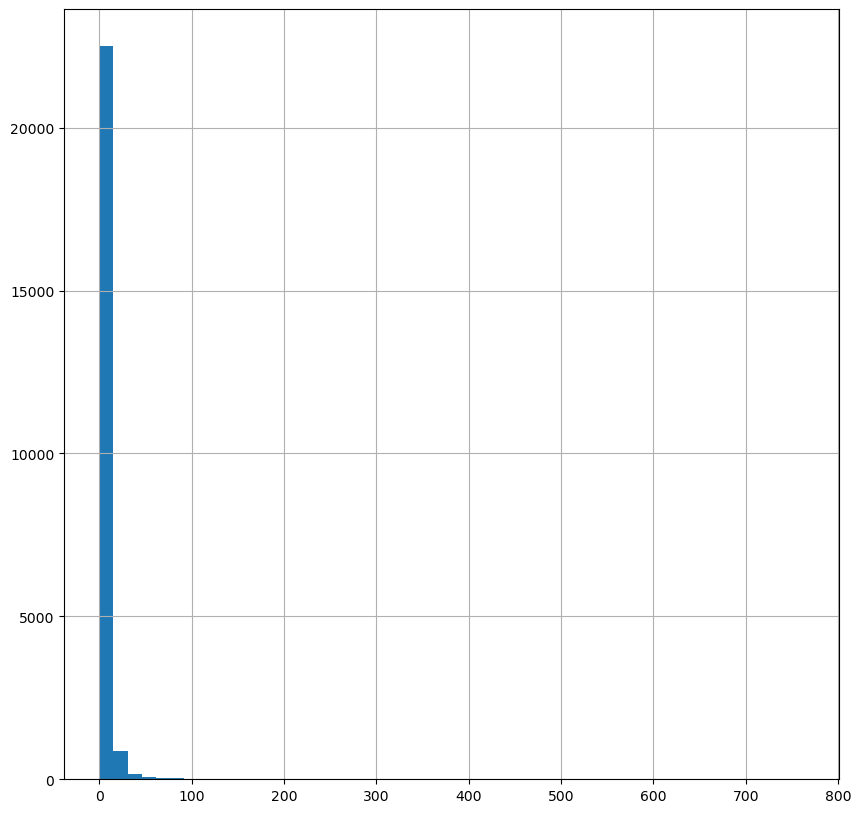

In [93]:
data['last_price'].hist(bins=50, figsize=(10, 10))

<AxesSubplot:>

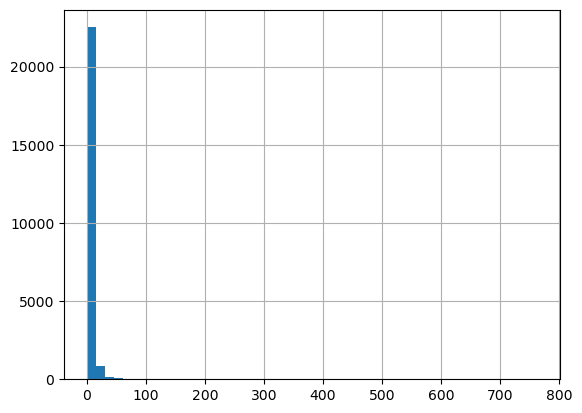

In [94]:
data.query('last_price < 30000000')['last_price'].hist(bins=50)

Гистограмма похожа на гистограмму нормального распределения с хвостом вправо к аномально дорогим квартирам. Наибольшее количество объявлений приходится на стоимость около 3,75 млн. руб.

**Количество комнат**

In [95]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

<AxesSubplot:>

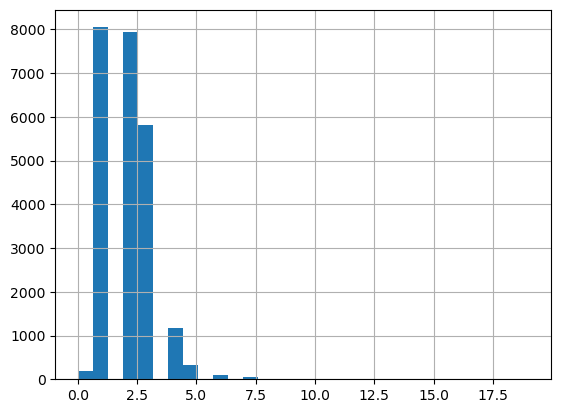

In [96]:
data['rooms'].hist(bins=30)

На гистограмме видно, что основная масса объявлений - о продаже квартир с количеством комнат от 1 до 3, небольшое количество квартир имеет 4 комнаты, и так же есть шестикомнатные варианты. Данные о квартирах с количеством комнат больше 6 похожи на выбросы. Для наглядности выведем график без хвоста.

<AxesSubplot:>

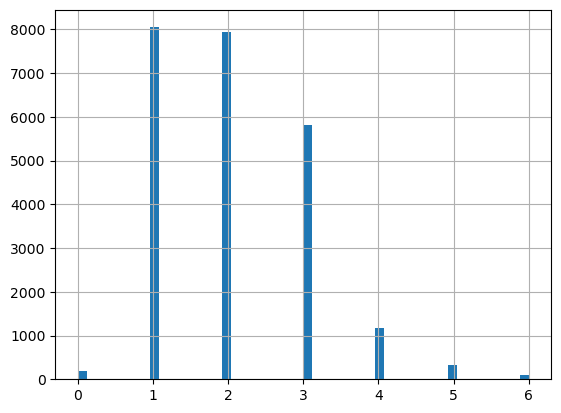

In [97]:
data.query('rooms <= 6')['rooms'].hist(bins=50)

Наибольшее количество объявление о продаже однокомнатных квартир.

**Высота потолка**

In [98]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.707974
std          0.307292
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max         20.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

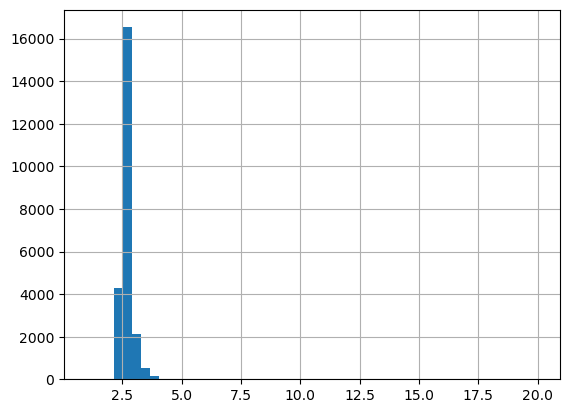

In [99]:
(data.loc[~data['ceiling_height'].isna(),'ceiling_height']).hist(bins=50)

Из описания данных следует, что минимальная высота потолка один метр, что является аномально низким значением, а максимальная сто метров, что является аномально высоким значением. Построим дополнительную гистограмму c высотой потолков меньше пяти метров и больше, чем 2,3 м. Без аномальных значений, чтобы лучше изучить данные.

<AxesSubplot:>

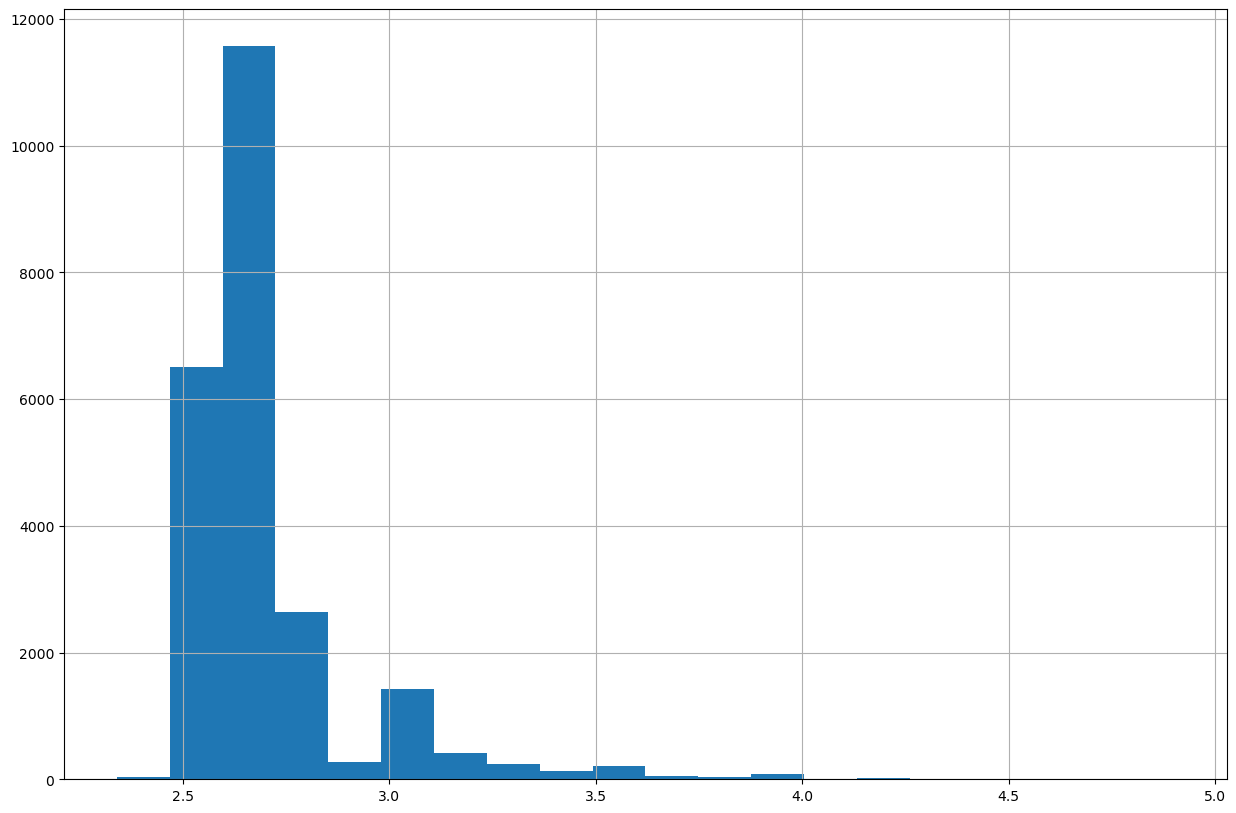

In [100]:
(data.loc[
    (data['ceiling_height'].notna()) 
    & (data['ceiling_height'] < 5) 
    &(data['ceiling_height'] > 2.3), 'ceiling_height']).hist(bins=20, figsize=(15, 10)
     )

Построим ящик с усами, чтобы определить размах значений.

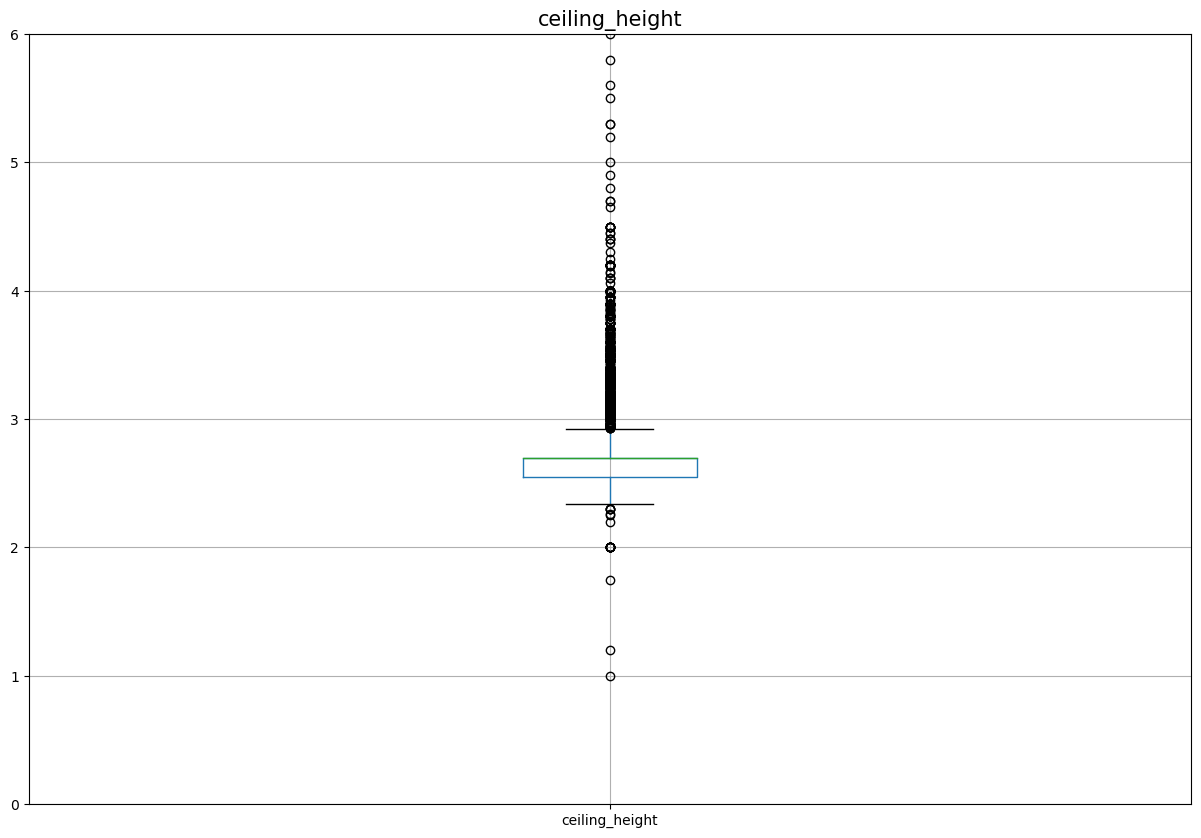

In [101]:
plt.figure(figsize=(15, 10))
data.boxplot(column='ceiling_height')
plt.title('ceiling_height', fontsize=15)
plt.ylim(0, 6)
plt.show()

Основная часть квартир расположена в диапазоне 2,4-2,7 метров, к 3,5 метрам количество сокращается, а потолки выше 4,5 практически не встречаются.

**Этаж**

In [102]:
data['floor'].describe()

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot:>

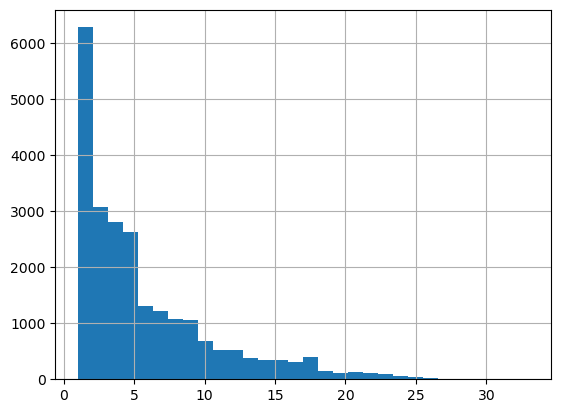

In [103]:
data['floor'].hist(bins=30)

Большинство объявлений находятся в диапазоне от 1 до 5 этажа. Построим вторую гистограмму, чтобы подробнее рассмотреть количество квартир на более высоких этажах.

<AxesSubplot:>

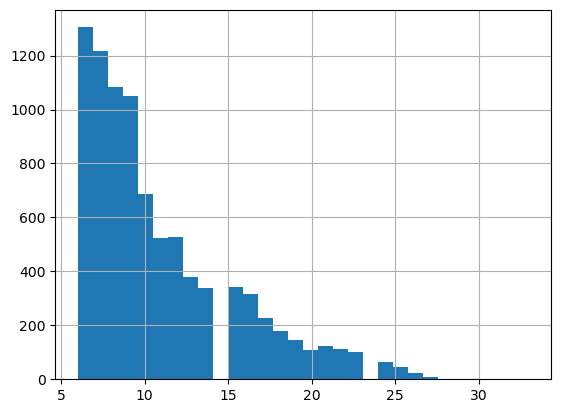

In [104]:
data.loc[(data['floor'] > 5), 'floor'].hist(bins=30)

В этом случае большинство объектов находятся между 6 и 9 этажами, далее количество выставленных площадей снижается, отднако есть одиночные выбросы после 25 этажа и даже после 30.

**Тип этажа квартиры**

In [105]:
data['floor_category'].describe()

count      23699
unique         3
top       другой
freq       17446
Name: floor_category, dtype: object

<AxesSubplot:>

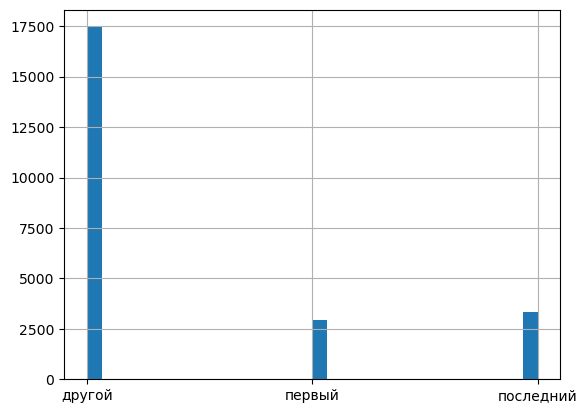

In [106]:
data['floor_category'].hist(bins=30)

Из представленной гистограммы следует, что большинство продающихся квартир находятся между первым этажом и последним. Наименьшее количество жилья продается на первом этаже.

In [107]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

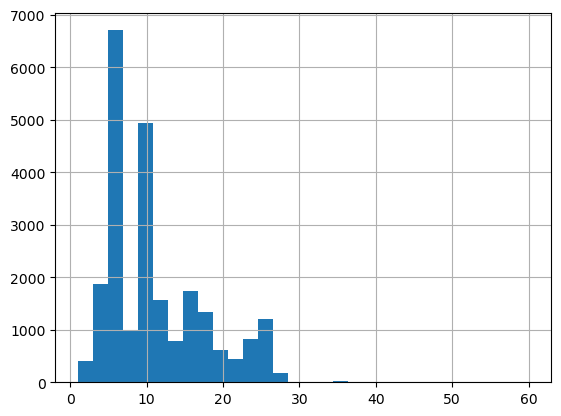

In [108]:
data['floors_total'].hist(bins=30)

<AxesSubplot:>

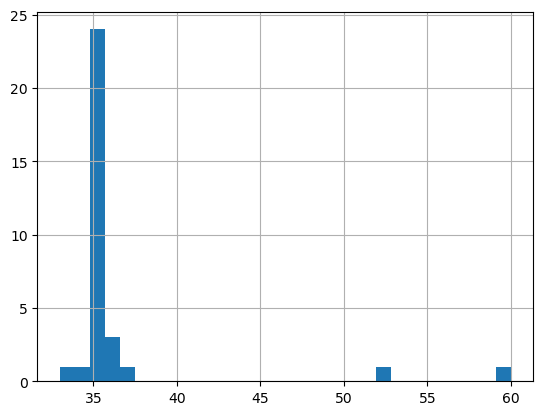

In [109]:
data.query('floors_total > 30')['floors_total'].hist(bins=30)

Из данных представленных на гистограме, мы видим, что есть дома, количество этажей в которых больше тридцати, при этом в столбце с указанием на этаж расположение квартиры максимальное значение 33. Дома с этажностью больше 50 похожи на единичные выбросы. При этом на общей гистограмме мы видим, что большая часть жилья расположена между первым и пятым этажами, второй всплеск приходится на диапазон от девятого до двенадцатого этажа.

**Расстояние до центра города в метрах**

In [110]:
data['cityCenters_nearest'].describe()

count    18305.000000
mean     14231.683201
std       8625.989235
min        181.000000
25%       9274.000000
50%      13101.000000
75%      16326.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:>

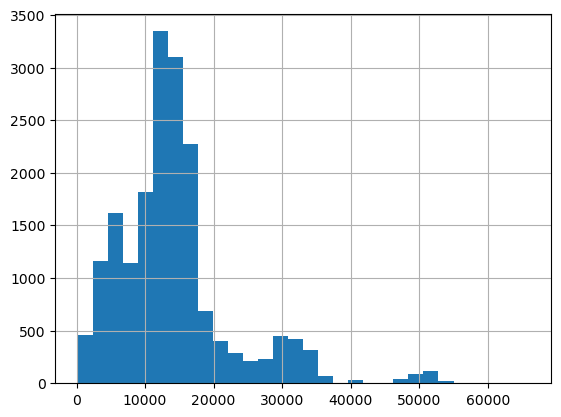

In [111]:
data['cityCenters_nearest'].hist(bins=30)

<AxesSubplot:>

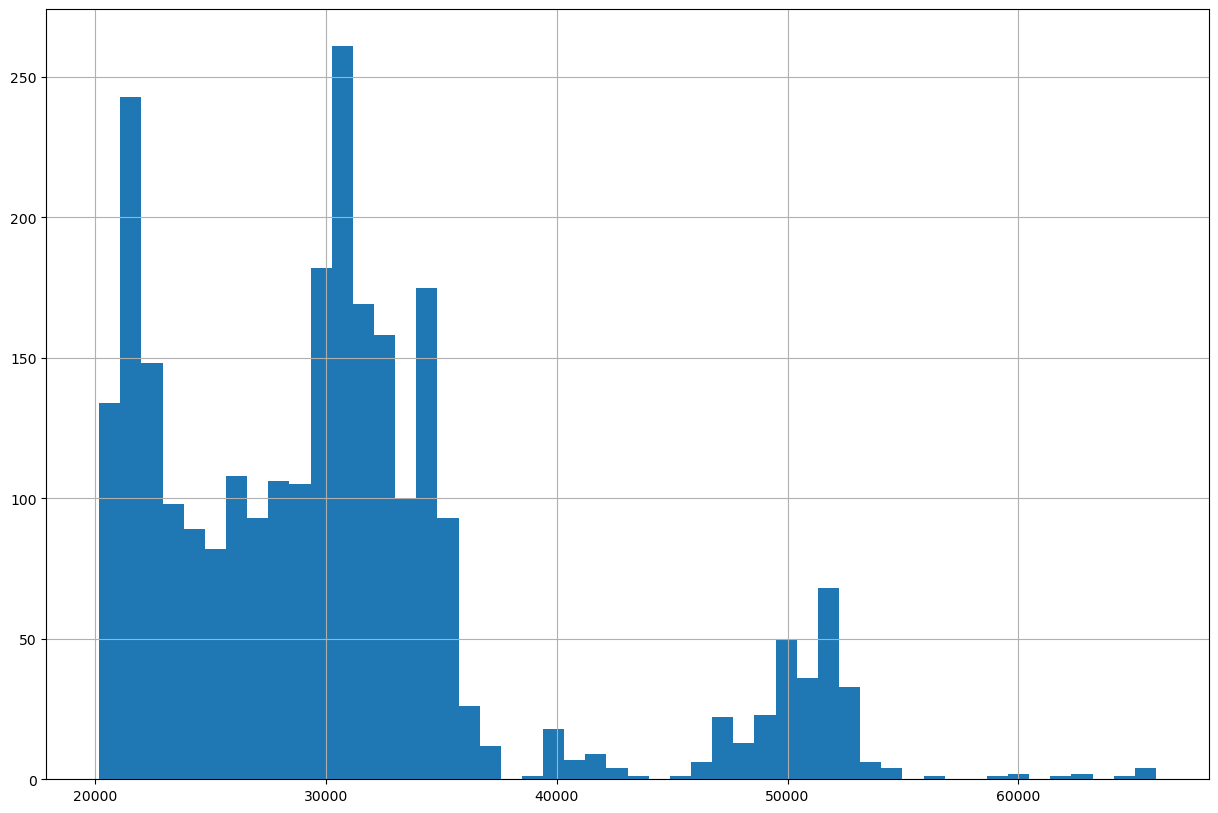

In [112]:
data.query('cityCenters_nearest > 20000')['cityCenters_nearest'].hist(bins=50, figsize=(15,10))

По общему графику видно, что большая часть квартир расположена в пределах 3-20 км. от центра.Так же есть всплеск в районе 30 км. В целом распределение походит на нормальное.

**Расстояние до ближайшего аэропортра**

In [113]:
data['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<AxesSubplot:>

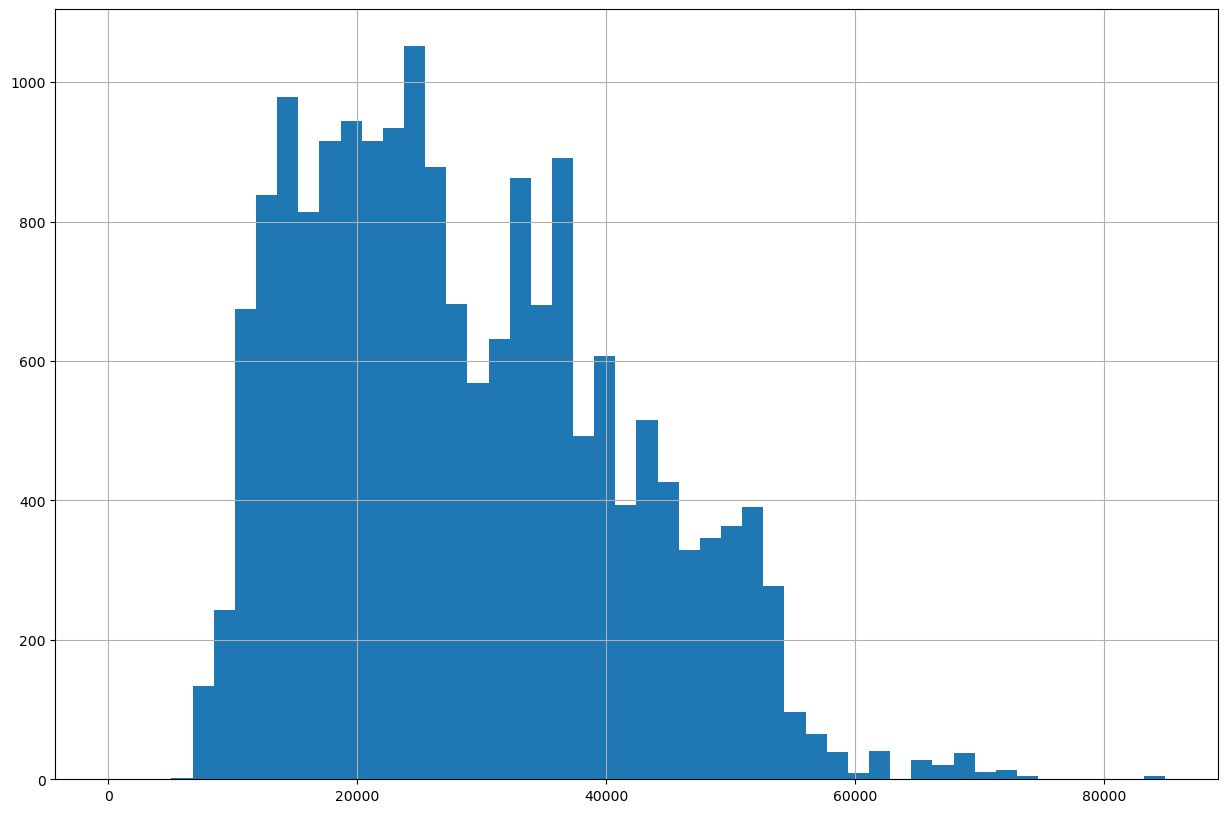

In [114]:
data['airports_nearest'].hist(bins=50, figsize=(15, 10))

Большая часть выставленного на продажу жилья находится на удалении от 10 до 40 км. от ближайших аэропортов.

**Расстояние до ближайшего парка**

In [115]:
data['parks_nearest'].describe()

count    23699.000000
mean       167.315499
std        306.709997
min          0.000000
25%          0.000000
50%          0.000000
75%        301.000000
max       3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:>

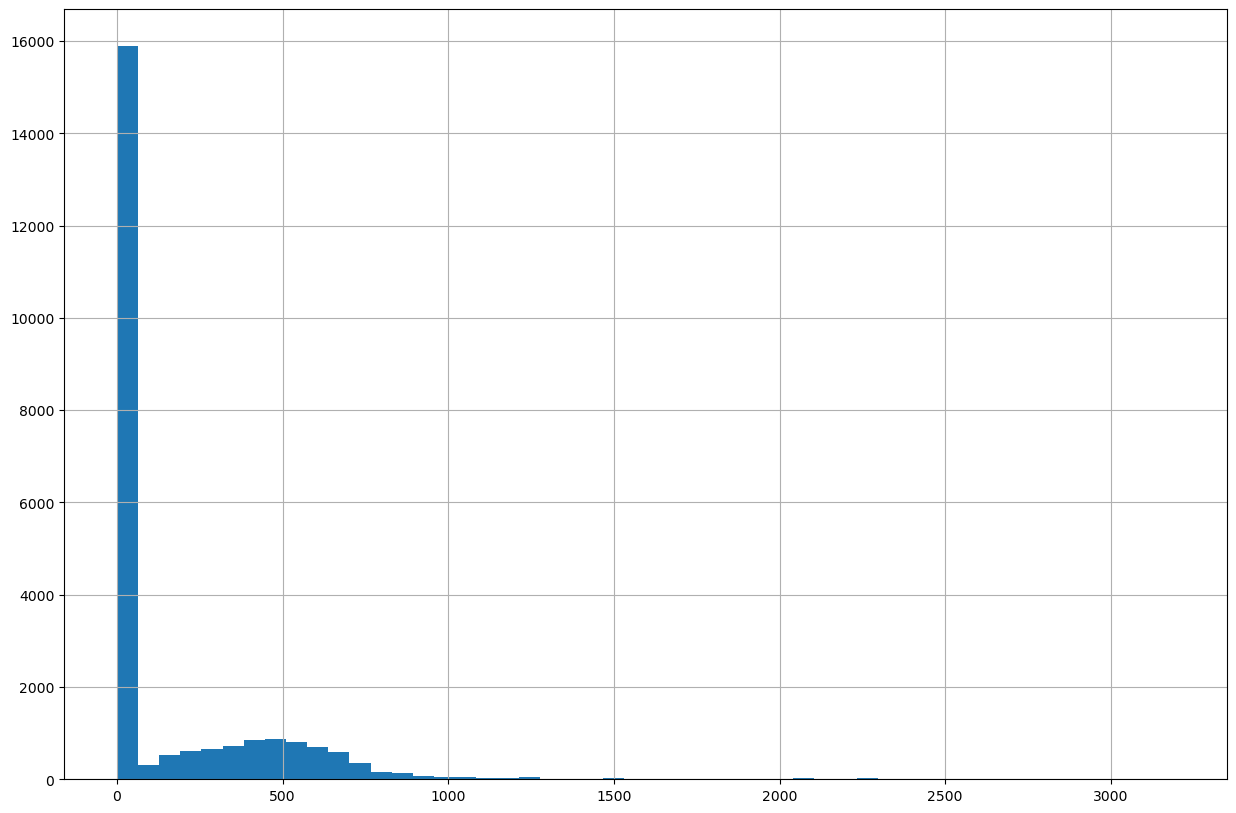

In [116]:
data['parks_nearest'].hist(bins=50, figsize=(15,10))

<AxesSubplot:>

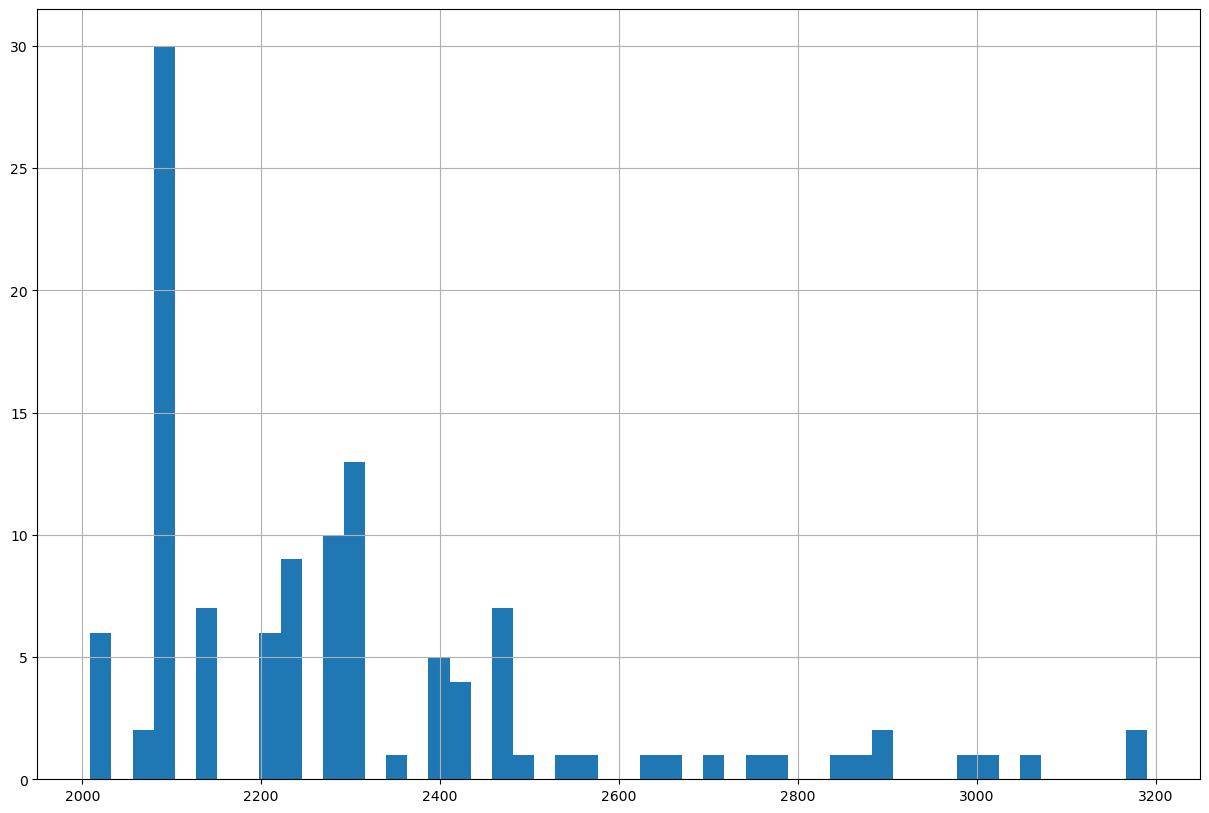

In [117]:
data.query('parks_nearest > 2000')['parks_nearest'].hist(bins=50, figsize=(15, 10))

На гистограмме видно большое количество объектов с расстоянием 0. Первоначально датасет имел более 15000 пропущенных значений в столбце и было принято решение заменить пропуски на ноль, при условии, что в радиусе трех километров (в столбце parks_around3000) так же нет данных. Однако на представленном графике видно, что встречаются расстония до ближайшего парка более трех километров. Что может говорить о том, что причина пропусков не только в отстутвии парков рядом с объектами недвижимости, и ставить под вопрос замену пропусков нулем.

**День и месяц публикации объявления**

In [118]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

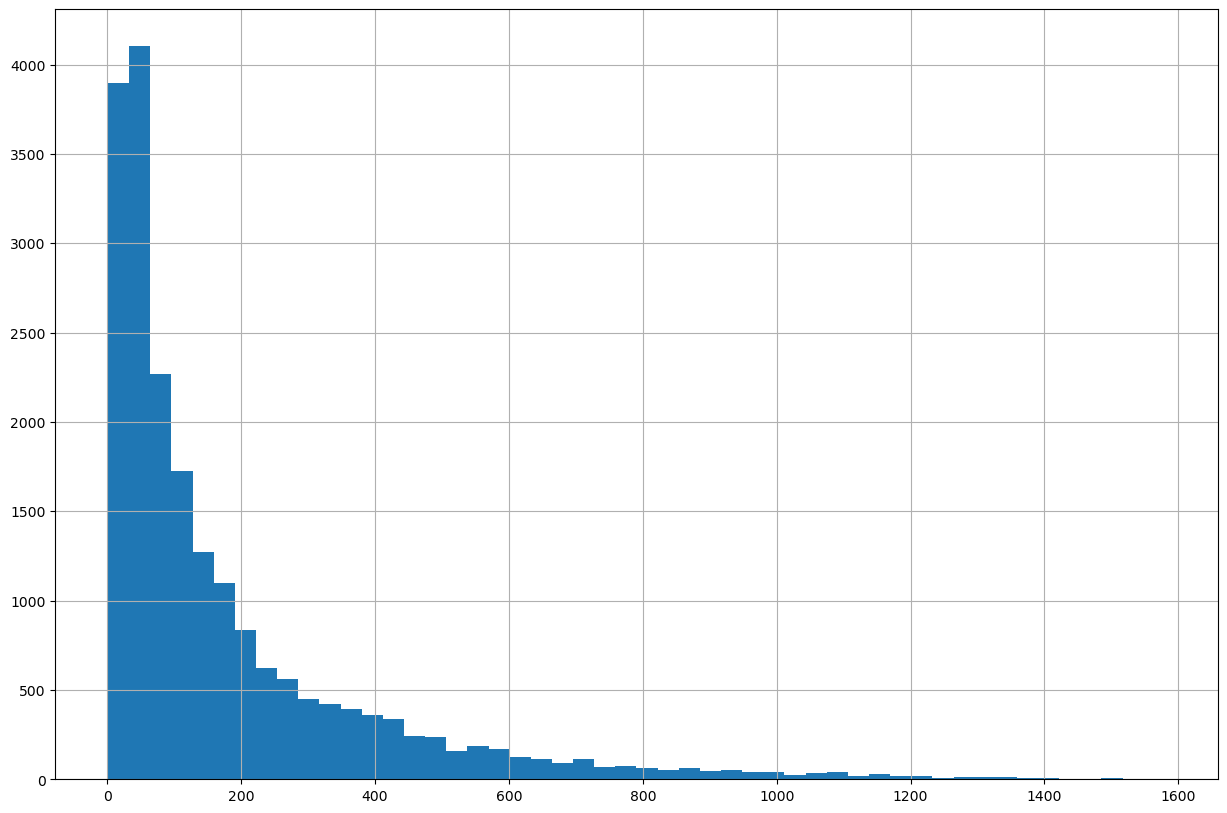

In [119]:
data['days_exposition'].hist(bins=50, figsize=(15,10))

<AxesSubplot:>

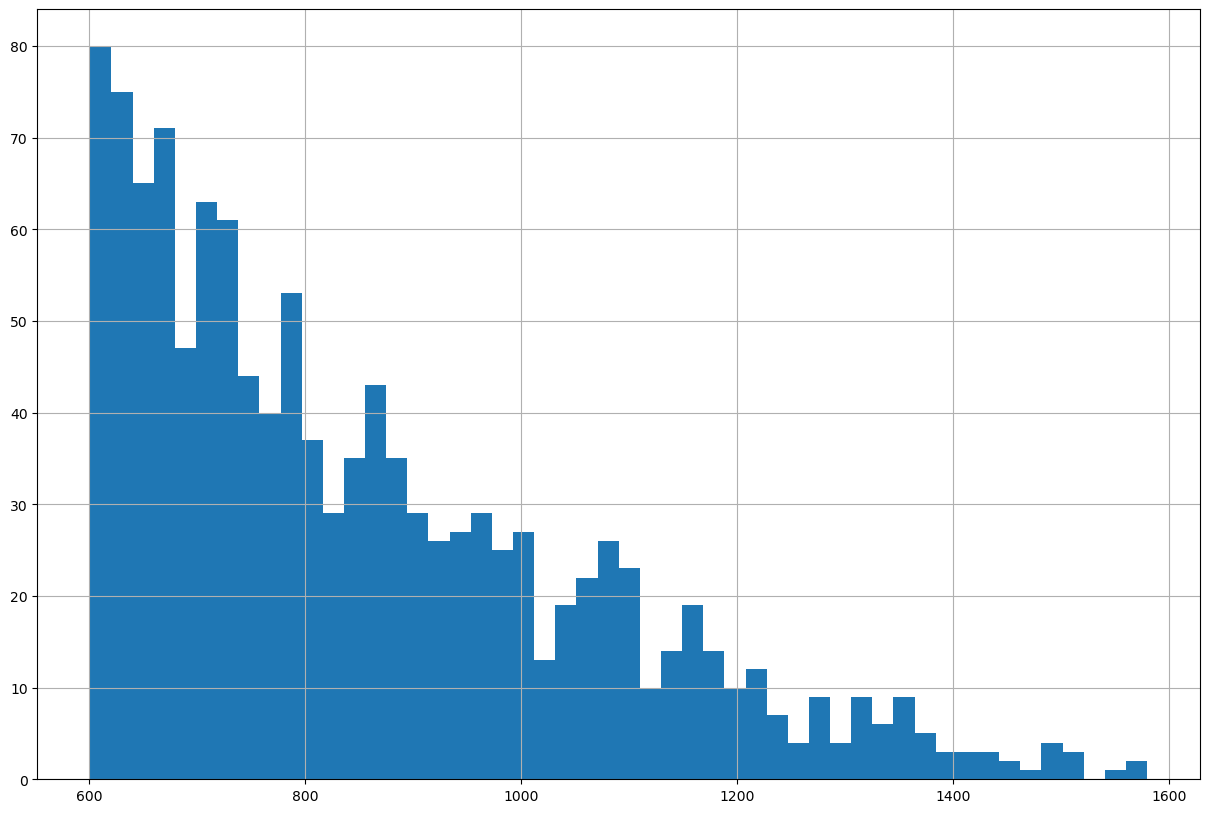

In [120]:
data.query('days_exposition > 600')['days_exposition'].hist(bins=50, figsize=(15,10))

По представленным графикам можно сделать вывод, что большая часть квартир продается в течение первых шести месяцев с моменты размещения. Довольно большое количество объявлений снимаются спустя короткое время после размещения, но на вопрос о причинах такого снятия ответить без вспомогательных данных затруднительно.

**День и месяц размещения публикации**

<AxesSubplot:>

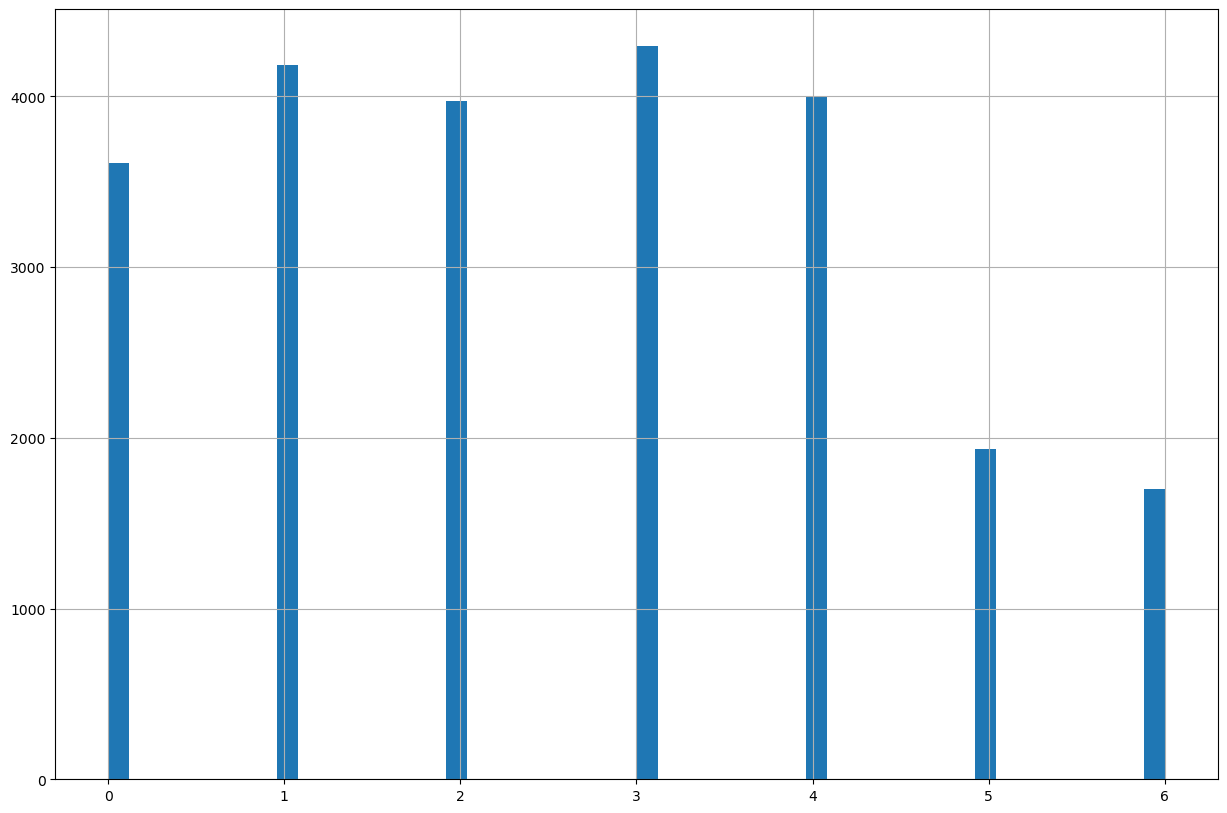

In [121]:
data['day'].hist(bins=50, figsize=(15,10))

По визуализации дней размещения публикаций можно отметить снижение их количества по дням, приходящимся на субботы и воскресенья, что связано скорее всего с общим понижением пользовательской и деловой активности.

<AxesSubplot:>

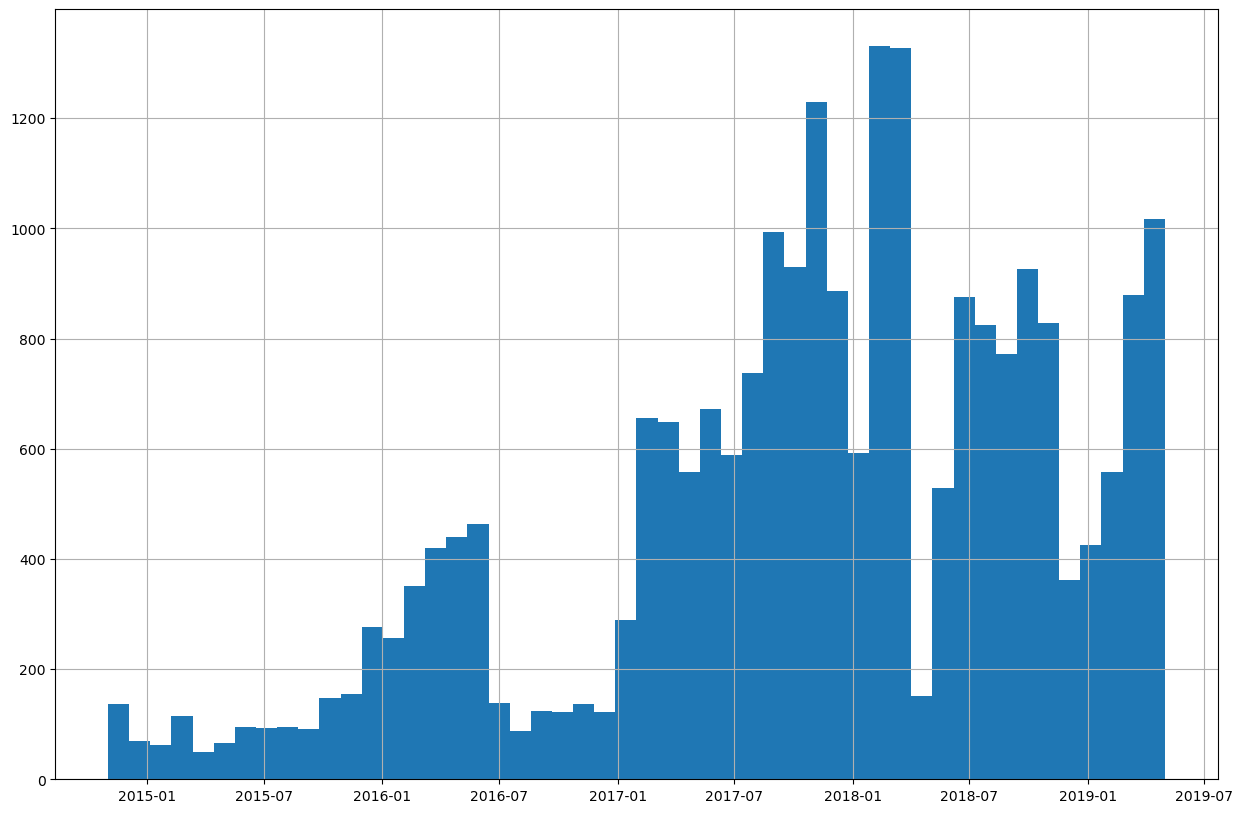

In [122]:
data['month'].hist(bins=50, figsize=(15,10))

Наибольшее количество публикаций пришлось на январь 2018 года, в то время, как наименьшее на январь 2015 г. Основная масса объявлений была размещена с января 2017 года по июль 2018. Можно обратить внимание на значительное снижение количества публикаций, пришедшемся на весну 2018 года.

#### Изучите, как быстро продавались квартиры (столбец days_exposition)

Изучим, как быстро продавались квартиры. Для этого обратимся к столбцу *days_exposition*.

In [123]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

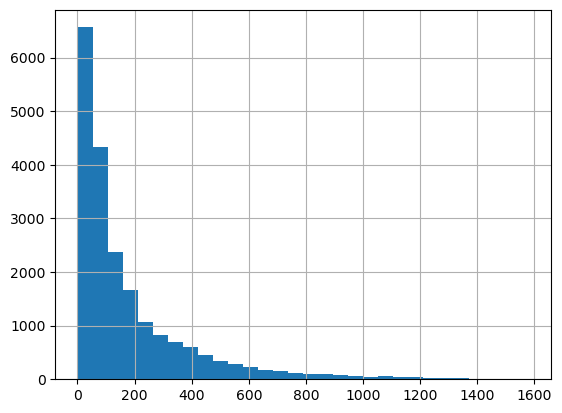

In [124]:
data['days_exposition'].hist(bins=30)

In [125]:
display('Среднее время продажи: {:0.0f} день'.format(data['days_exposition'].mean()))
display('Среднее время продажи: {:0.0f} дней'.format(data['days_exposition'].median()))

'Среднее время продажи: 181 день'

'Среднее время продажи: 95 дней'

В предыдущем исследовании мы отсекали хвост и подробнее рассматривали правую часть - с наибольшим временем размещения. Теперь подробнее рассмотрим левую часть.

<AxesSubplot:>

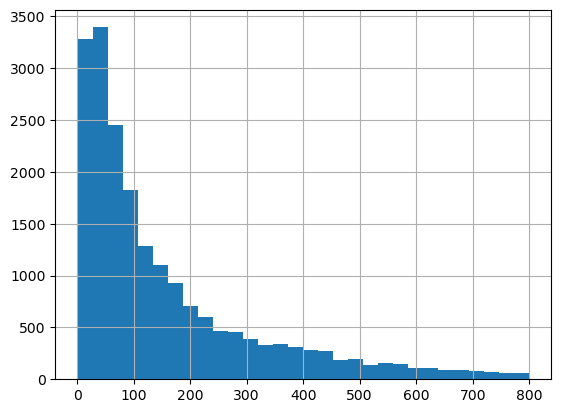

In [126]:
data.query('days_exposition < 800')['days_exposition'].hist(bins=30)

При оценке среднего и медианы, можно отметить, что между ними существенная разница, так же, как и большое значение стандартного отклонения, что скорее всего связано с небольшим количеством объявлений, который размещены на сайте аномально долго. При прогнозировании сроков продажи средней квартиры, а не слишком специфической, в данном случае стоило бы опираться на среднее значение.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Перед началом исследования соберем датасет из необходимых столбцов, с отфильтрованными данными. Нам понадобятся следующие столбцы: 
>общая площадь;

>жилая площадь;

>площади кухни;

>количество комнат;

>этаж, на котором расположена квартира (первый, последний, другой);

>даты размещения (день недели, месяц, год).

Сопоставим значения столбца *last_price* и *total_area*

Text(0.5, 1.0, 'Как размер общей площади влияет на стоимость')

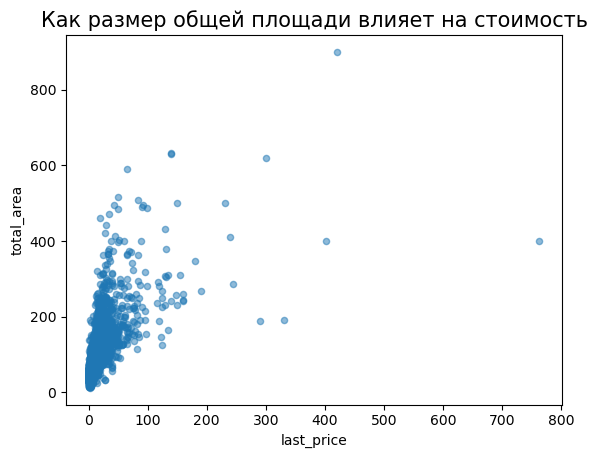

In [127]:
data.plot.scatter(x='last_price',
                         y='total_area',
                         alpha=0.5)
plt.title('Как размер общей площади влияет на стоимость', fontsize=15)

В столбце *living_area* уберем пропуски.

In [128]:
data_filter = data.dropna(subset=['living_area'])
display(data_filter['living_area'].isna().sum())

0

Аналогично построим диаграмму рассеяния для жилой площади.

Text(0.5, 1.0, 'Как размер жилой площади влияет на стоимость')

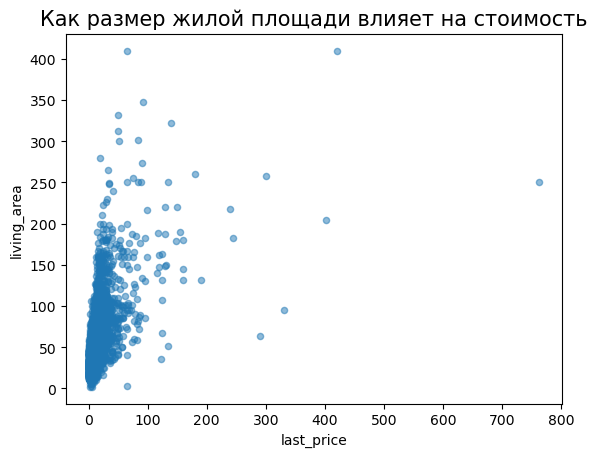

In [129]:
data_filter.plot.scatter(x='last_price',
                         y='living_area',
                         alpha=0.5)
plt.title('Как размер жилой площади влияет на стоимость', fontsize=15)

Аналогино для столбца *kitchen_area*.

In [130]:
data_filter = data.dropna(subset=['kitchen_area'])
display(data_filter['kitchen_area'].isna().sum())

0

Text(0.5, 1.0, 'Как площадь кухни влияет на стоимость')

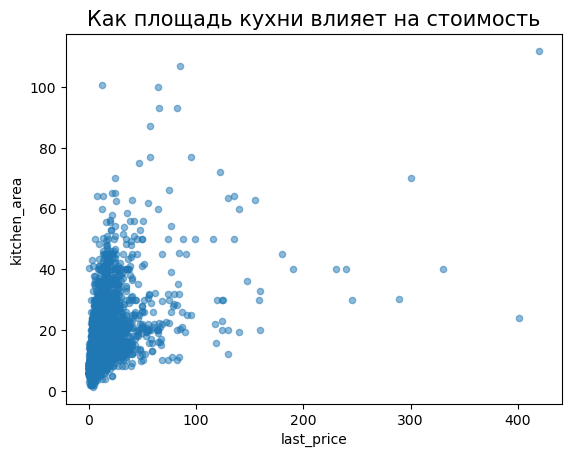

In [131]:
data_filter.plot.scatter(x='last_price',
                         y='kitchen_area',
                         alpha=0.5)
plt.title('Как площадь кухни влияет на стоимость', fontsize=15)

Text(0.5, 1.0, 'Как количество комнат влияет на стоимость')

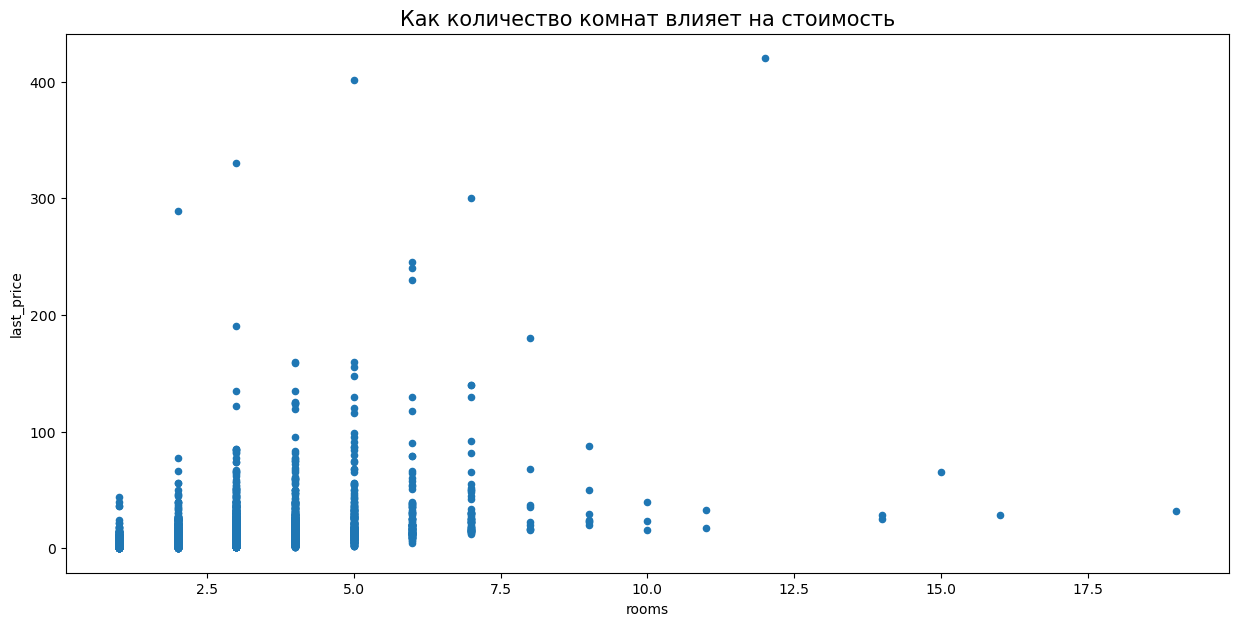

In [132]:
data_filter.plot(y='last_price',x='rooms',kind='scatter', figsize=(15, 7))
plt.title('Как количество комнат влияет на стоимость', fontsize=15)

Если комнат 0, то это студия, при этом количество комнат больше 6 встречается редко, что подтверждается гистограмой, постороеной ранее, поэтому для этого столбца оставим только те объекты, в которых от 0 до 6 комнат.

Рассмотрим влияние дня, месяца и года публикации на стоимость квартир.

In [133]:
day_of_sale = pd.pivot_table(data_filter, index='day', values='last_price',)
day_of_sale.sort_values(by='last_price', ascending=False).reindex()

,last_price
day,
3,6.788598
0,6.636162
2,6.597715
5,6.589023
1,6.467895
6,6.389431
4,6.263964


Text(0.5, 1.0, 'Зависимость стоимости от дня публикации')

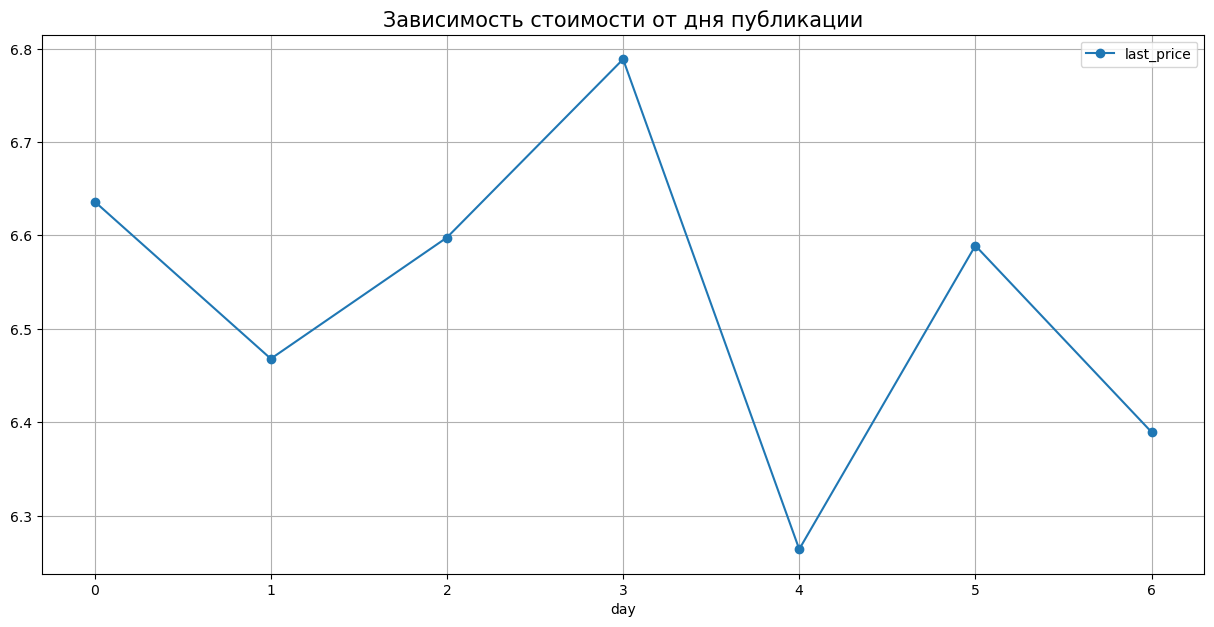

In [134]:
day_of_sale.plot(y='last_price',style='o-', grid=True, figsize=(15, 7))
plt.title('Зависимость стоимости от дня публикации', fontsize=15)

Самые дорогие квартиры по пятницам, но забегая вперед, скажем, что корреляция двух факторов отрицательная.

Аналогично для столбца *month*

,last_price
month_exposition,
12,7.193931
4,6.806871
1,6.638877
5,6.630659
2,6.592447


Text(0.5, 1.0, 'Зависимость стоимости от месяца публикации')

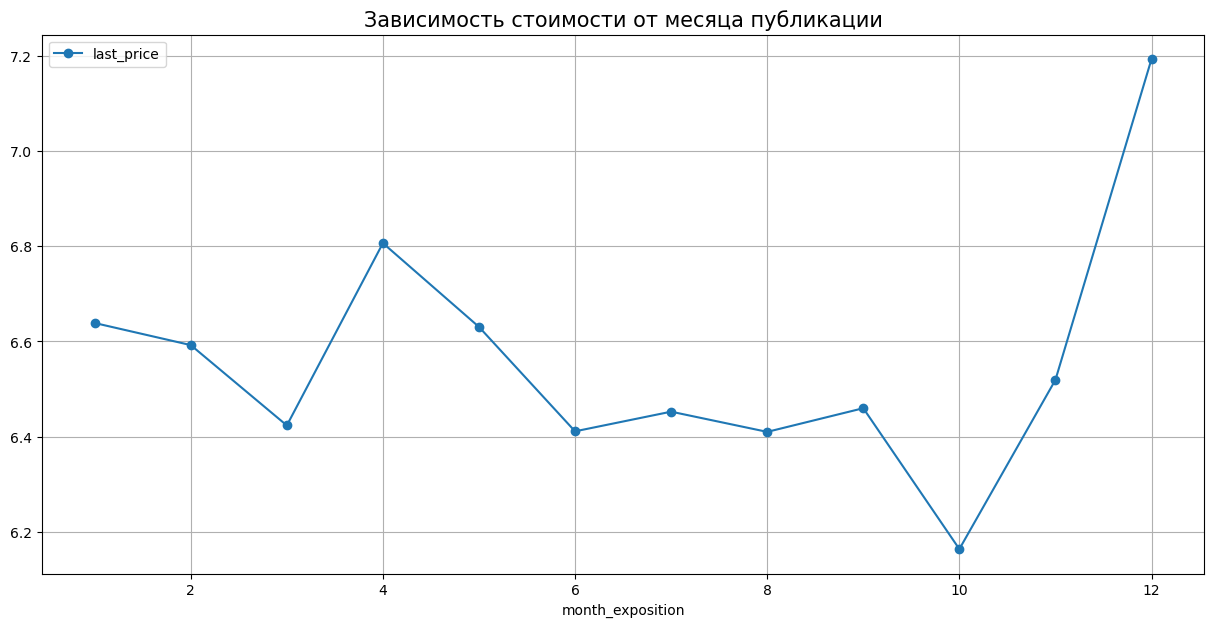

In [135]:
data_filter['month_exposition'] = data_filter['first_day_exposition'].dt.month
month_of_sale = pd.pivot_table(data_filter, index='month_exposition', values='last_price')

display(month_of_sale.sort_values(by='last_price', ascending=False).reindex().head(5))
month_of_sale.plot(y='last_price',style='o-', grid=True, figsize=(15, 7))
plt.title('Зависимость стоимости от месяца публикации', fontsize=15)

Объявления с самыми низкими ценами публикуются в марте и ноябре, а с самыми высокими в апреле и в декабре.

,last_price
mesyac,
12,7.193931
4,6.806871
1,6.638877
5,6.630659
2,6.592447


Text(0.5, 1.0, 'Зависимость стоимости от месяца публикации')

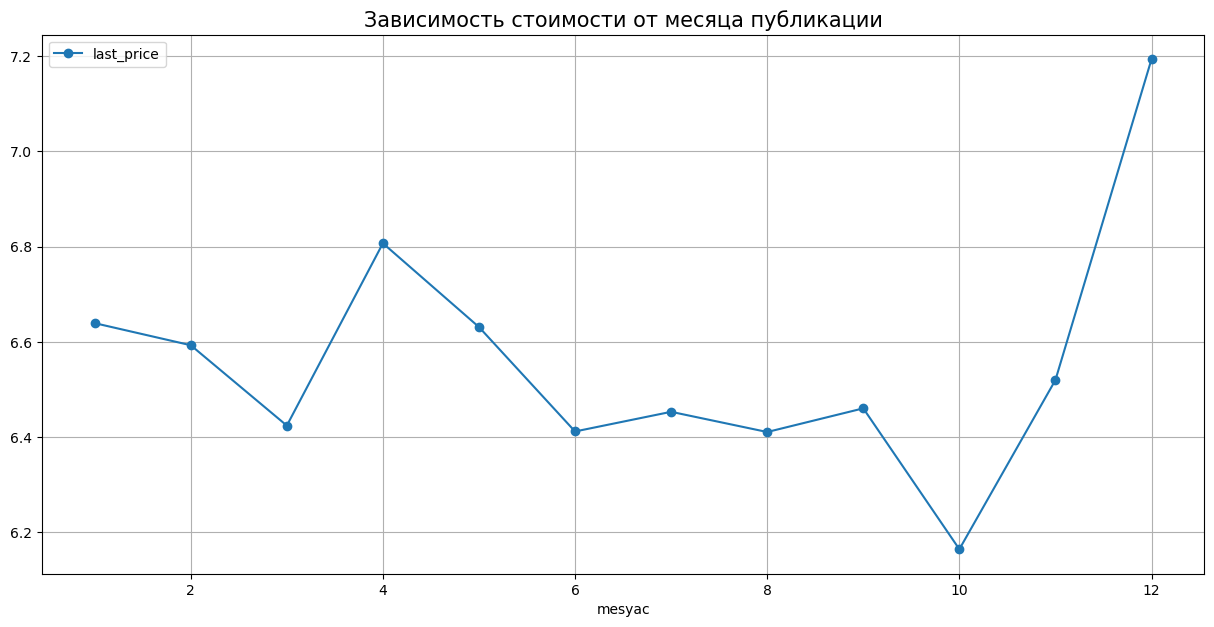

In [136]:
data_filter['mesyac'] = data_filter['first_day_exposition'].dt.month
month_of_sale = pd.pivot_table(data_filter, index='mesyac', values='last_price')
#month_of_sale_double = pd.read_csv(month_of_sale, index_col=0, parse_dates=True)
display(month_of_sale.sort_values(by='last_price', ascending=False).reindex().head(5))
month_of_sale.plot(y='last_price',style='o-', grid=True, figsize=(15, 7))
plt.title('Зависимость стоимости от месяца публикации', fontsize=15)

Text(0.5, 1.0, 'Зависимость стоимости от месяца публикации')

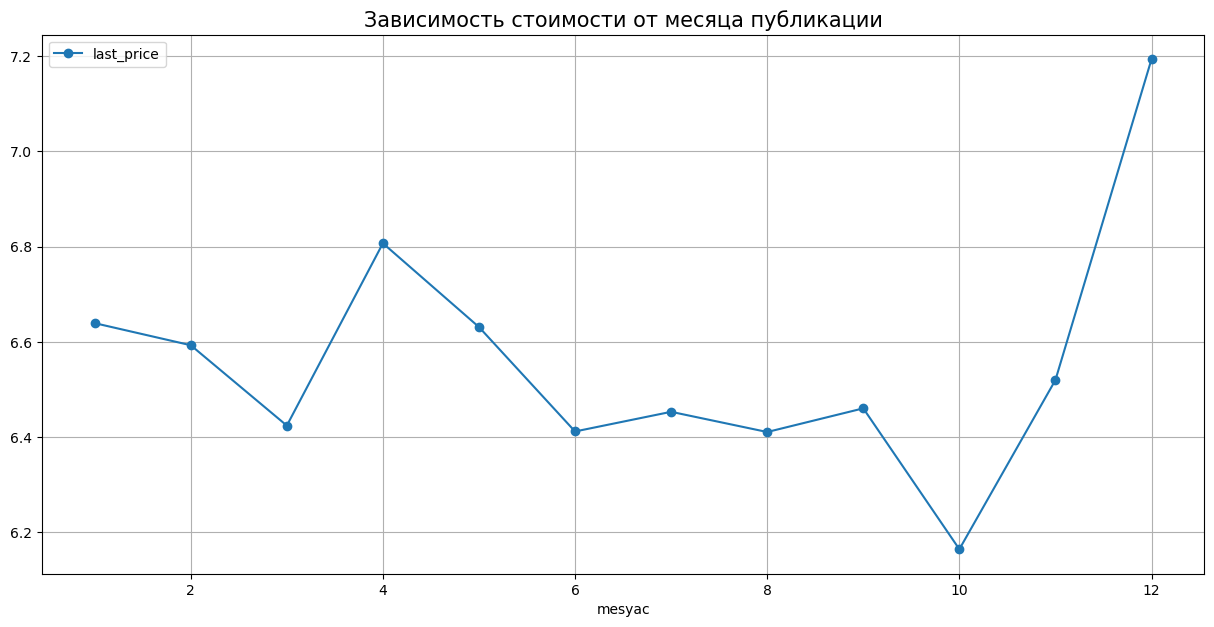

In [137]:
month_of_sale.plot(y='last_price',style='o-', grid=True, figsize=(15, 7))
plt.title('Зависимость стоимости от месяца публикации', fontsize=15)

Аналогично для столбца *year*

In [138]:
year_of_sale = pd.pivot_table(data_filter, index='year', values='last_price',)
year_of_sale.sort_values(by='last_price', ascending=False).reindex()

,last_price
year,
2014,12.006175
2015,8.340552
2019,6.758662
2016,6.722740
2017,6.529096
2018,6.065685


Text(0.5, 1.0, 'Зависимость стоимости от года публикации')

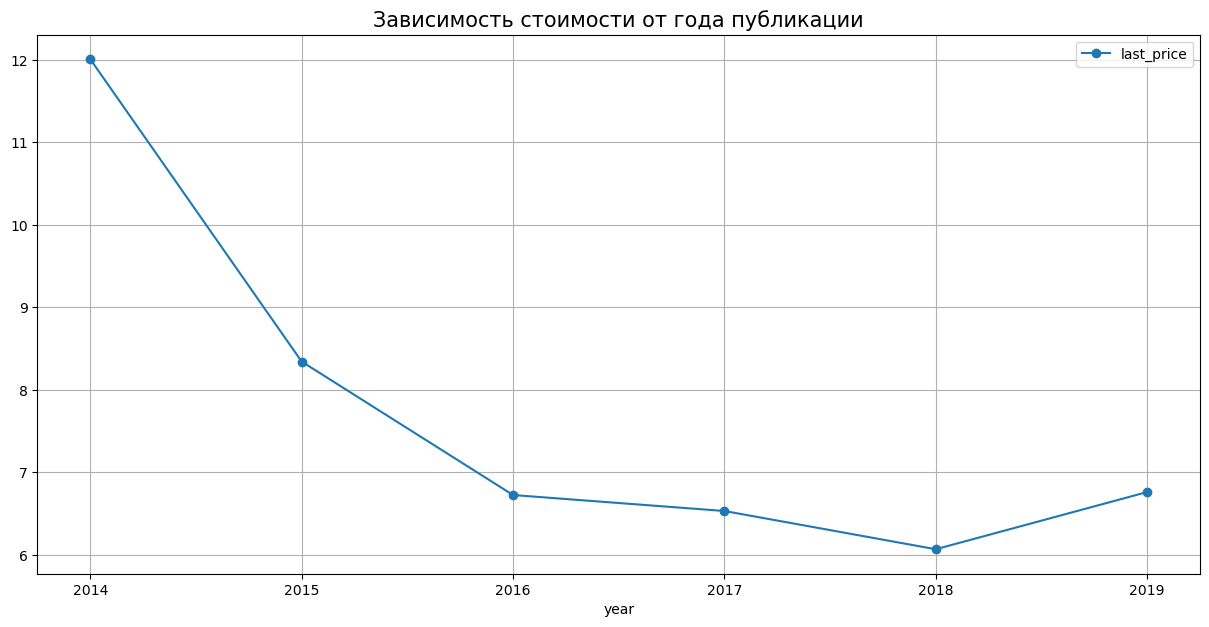

In [139]:
year_of_sale.plot(y='last_price',style='o-', grid=True, figsize=(15, 7))
plt.title('Зависимость стоимости от года публикации', fontsize=15)

Построенный график демонстрирует нам обратную некоторую обратную зависимость. Самые дорогие квартиры были размещены в 2014 году, самые дешевые в 2018 году. В 2019 средняя цена немного подросла, относительно 2018 года. Но скорее всего это связано не с самим годом публикации, а с экономической и геополитической ситуацией.

In [140]:
data_filtered = data.query('(last_price < 30000000) & (0 <= total_area <= 150) & (10 <= living_area <=100) & (2 <= kitchen_area <= 25) & (0 <= rooms <= 6) & (2.1 <= ceiling_height <= 10)')
display(data_filtered)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day,month,year,floor_category,cityCenters_km
0,20,13.000,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,482,2,755,NaN,0,3,2019-03-01,2019,другой,16.0
1,7,3.350,40.40,2018-12-04,1,2.63,11.0,18.6,1,False,...,0,0,0,81.0,0,1,2018-12-01,2018,первый,19.0
2,10,5.196,56.00,2015-08-20,2,2.70,5.0,34.3,4,False,...,90,2,574,558.0,0,3,2015-08-01,2015,другой,14.0
5,10,2.890,30.40,2018-09-10,1,2.60,12.0,14.4,5,False,...,0,0,0,55.0,0,0,2018-09-01,2018,другой,0.0
6,6,3.700,37.30,2017-11-02,1,2.64,26.0,10.6,6,False,...,0,0,0,155.0,0,3,2017-11-01,2017,другой,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1.350,30.00,2017-07-07,1,2.60,5.0,17.5,4,False,...,0,0,0,413.0,0,4,2017-07-01,2017,другой,0.0
23693,9,4.600,62.40,2016-08-05,3,2.60,9.0,40.0,8,False,...,352,1,675,239.0,0,4,2016-08-01,2016,другой,34.0
23694,9,9.700,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,796,3,381,NaN,0,1,2017-03-01,2017,другой,4.0
23695,14,3.100,59.00,2018-01-15,3,2.50,5.0,38.0,4,False,...,0,0,0,45.0,0,0,2018-01-01,2018,другой,0.0


Вопрос стоит в зависимости цены продажи от рассматриваемых выше факторов. Посмотрим на коэффциенты корреляции:

In [141]:
correlation = data_filtered.corr()
correlation.sort_values('last_price', ascending=False)['last_price'].reset_index().head()

,index,last_price
0,last_price,1.000000
1,total_area,0.689950
2,living_area,0.591177
3,kitchen_area,0.495585
4,rooms,0.407740


Построим более развернутый график, в котором отобразим интересующие нас столбцы:

In [142]:
corr = data_filtered[['last_price',\
           'total_area',\
           'living_area',\
           'kitchen_area',\
           'rooms',\
           'day',\
           'month',\
            'year'    
               ]].corr()
corr.style.background_gradient(cmap='Greys')

,last_price,total_area,living_area,kitchen_area,rooms,day,year
last_price,1.000000,0.689950,0.591177,0.495585,0.407740,-0.014642,-0.028377
total_area,0.689950,1.000000,0.928579,0.519444,0.796146,-0.010978,-0.075980
living_area,0.591177,0.928579,1.000000,0.276792,0.885989,-0.006511,-0.060584
kitchen_area,0.495585,0.519444,0.276792,1.000000,0.121098,-0.011313,-0.054200
rooms,0.407740,0.796146,0.885989,0.121098,1.000000,-0.000167,-0.045040
day,-0.014642,-0.010978,-0.006511,-0.011313,-0.000167,1.000000,-0.004567
year,-0.028377,-0.075980,-0.060584,-0.054200,-0.045040,-0.004567,1.000000


Итак, по приведенной визуализации можно сказать, что сильнее всего влияет на цену продажи общая площадь квартиры, потом жилая площадь и площадь кухни. В меньшей степени цена продажи связана с количеством комнат. А вот день недели, месяц и год публикации объявления наоборот влияния на цену практически не оказывают.

Теперь рассмотрим влияние этажа на цену:

[Text(0, 0.5, 'цена'), Text(0.5, 0, 'этаж')]

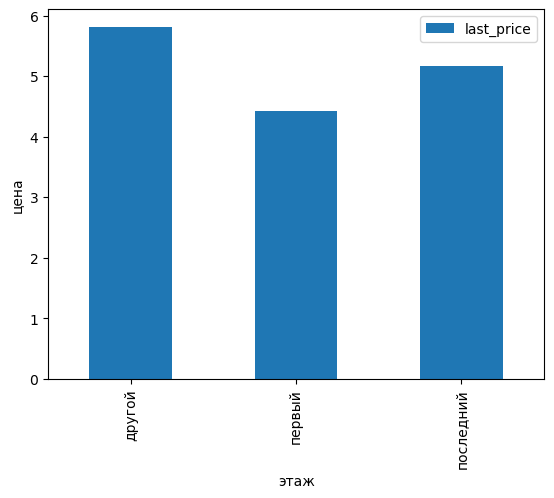

In [143]:
data_filtered.pivot_table(index='floor_category', values='last_price', aggfunc='mean')\
    .plot.bar().set(ylabel='цена', xlabel='этаж')

Если оценивать среднее значение, то про связь этажности с ценой продажи можно сказать, что квартиры на первом этаже дешевле, чем на последнем, а на последнем дешевле, чем на любом другому. Скорее всего это связано со спецификой проживания на первом и последнем этажах.

#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.

Перед расчетом стоимости квадратного метра изучим список первых десяти значений по количеству объявлений в датафрейме с отфильтрованными данными.

In [144]:
display((data_filtered['locality_name'].value_counts(ascending=False)).head(10))

санкт-петербург    13268
мурино               457
шушары               391
кудрово              371
всеволожск           352
колпино              320
пушкин               319
парголово            288
гатчина              286
петергоф             186
Name: locality_name, dtype: int64

Расчитаем стоимость квадратного метра, с округлением до двух знаков после запятой. Добавим данные в  новый столбец.

In [145]:
data_filtered['sq_meter'] = (data_filtered['last_price']/data_filtered['total_area']).round(decimals=2)
display(data_filtered['sq_meter'])

0        0.12
1        0.08
2        0.09
5        0.10
6        0.10
         ... 
23692    0.05
23693    0.07
23694    0.07
23695    0.05
23698    0.04
Name: sq_meter, Length: 20091, dtype: float64

In [146]:
sq_meter_price = data_filtered.pivot_table(index='locality_name', values='sq_meter', aggfunc=['count', 'min', 'max', 'median', 'mean'])
sq_meter_price.columns = ['count', 'min', 'max', 'median', 'mean']
final_list = sq_meter_price.sort_values('count', ascending=False).head(10)
display(final_list)

,count,min,max,median,mean
locality_name,,,,,
санкт-петербург,13268,0.02,1.00,0.10,0.110368
мурино,457,0.05,0.14,0.09,0.085930
шушары,391,0.05,0.13,0.08,0.078721
кудрово,371,0.05,0.16,0.10,0.095445
всеволожск,352,0.03,0.64,0.07,0.069205
колпино,320,0.05,0.12,0.07,0.075156
пушкин,319,0.06,0.26,0.10,0.102414
парголово,288,0.05,0.14,0.09,0.091111
гатчина,286,0.01,0.15,0.07,0.068706


Итак, мы видим, что из финального списка населенных пунктов самое высокое значение средней стоимости квадратного метра в городе Санкт-Петербурге, а самое низкое в Петергофе.

#### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

Выберем в отдельный датафрейм значения, для которых населенным пунктом указан город Санкт-Петербург и есть расстояние до центра в километрах.

In [147]:
data_spb = data_filtered[(data_filtered['locality_name'] == 'санкт-петербург') & data_filtered['cityCenters_km']]
display(data_spb)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day,month,year,floor_category,cityCenters_km,sq_meter
0,20,13.000,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,2,755,NaN,0,3,2019-03-01,2019,другой,16.0,0.12
2,10,5.196,56.00,2015-08-20,2,2.70,5.0,34.3,4,False,...,2,574,558.0,0,3,2015-08-01,2015,другой,14.0,0.09
9,18,5.400,61.00,2017-02-26,3,2.50,9.0,43.6,7,False,...,0,0,289.0,0,6,2017-02-01,2017,другой,15.0,0.09
10,5,5.050,39.60,2017-11-16,1,2.67,12.0,20.3,3,False,...,2,553,137.0,0,3,2017-11-01,2017,другой,14.0,0.13
15,16,4.650,39.00,2017-11-18,1,2.70,14.0,20.5,5,False,...,1,296,19.0,0,5,2017-11-01,2017,другой,14.0,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23688,19,9.200,101.00,2019-04-01,3,3.05,15.0,63.0,12,False,...,0,0,23.0,0,0,2019-04-01,2019,другой,14.0,0.09
23689,13,3.550,35.30,2018-02-28,1,2.86,15.0,16.3,4,False,...,2,652,29.0,0,2,2018-02-01,2018,другой,16.0,0.10
23690,3,5.500,52.00,2018-07-19,2,2.70,5.0,31.0,2,False,...,0,0,15.0,0,3,2018-07-01,2018,другой,6.0,0.11
23691,11,9.470,72.90,2016-10-13,2,2.75,25.0,40.3,7,False,...,1,806,519.0,0,3,2016-10-01,2016,другой,4.0,0.13


Далее, сделаем сводную таблицу, в которой каждому километру сопутствует средняя цена.

In [148]:
kilometer_price = data_spb.pivot_table(index=['cityCenters_km'], values=['sq_meter'], aggfunc='mean')
display(kilometer_price.head(5))

,sq_meter
cityCenters_km,
1.0,0.136970
2.0,0.148333
3.0,0.119811
4.0,0.124396
5.0,0.131294


Теперь построим график, который отобразит распределение средней цены за кватратный метр в зависимости от расстояния от центра в километрах.

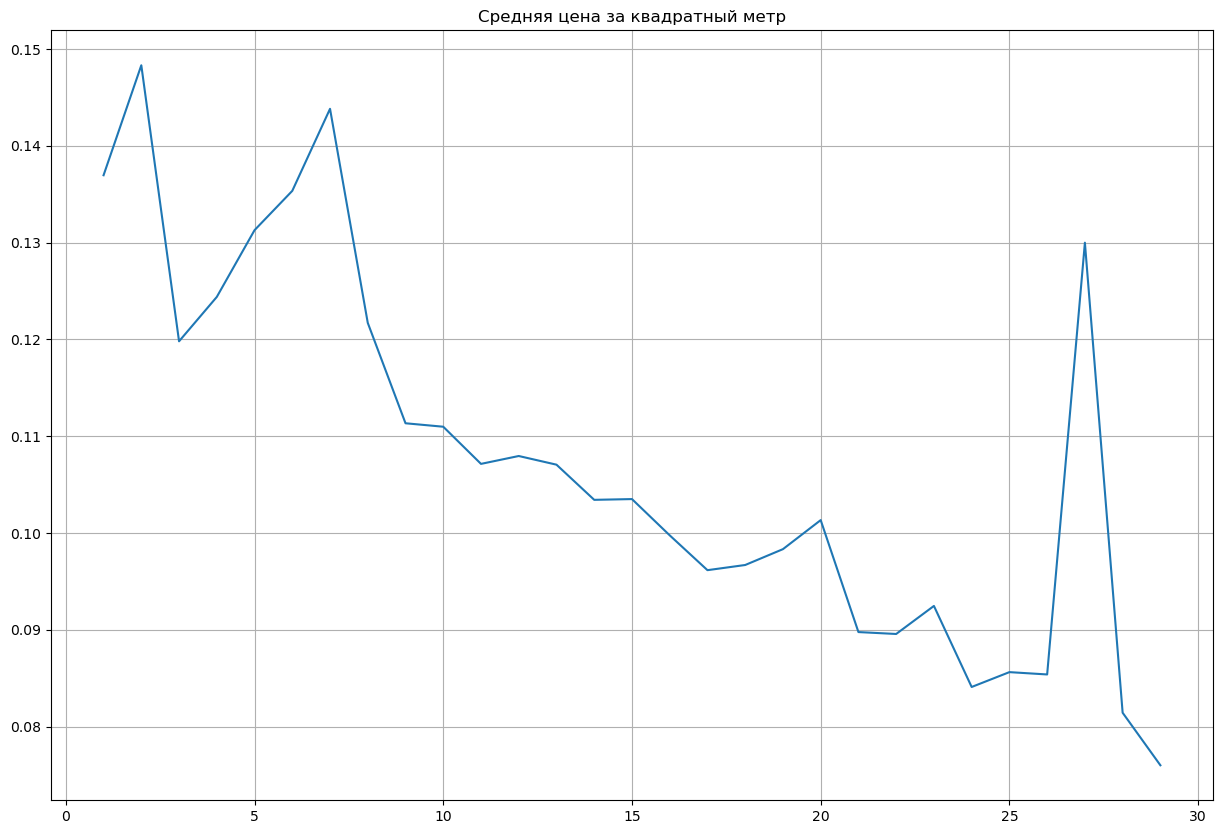

In [149]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(kilometer_price)
plt.title('Средняя цена за квадратный метр')
plt.show()

По графику можно отметить, что традиционно самое дорогое жилье расположено ближе к центру, однако на двадцать седьмом километре фиксируется значительное повышение цены, относительнно близлежащих районов. В целом, зависимость между стоимостью квадратного метра и удаленностью от центра прямая, чем ближе - тем дороже, чем дальше, тем дешевле.

Проведем небольшое дополнительное исследование, чтобы узнать, не связано ли повышение цены с общей площадью жилья.

In [150]:
kilometer_total_area = data_spb.pivot_table(index=['cityCenters_km'], values=['total_area'])
display(kilometer_total_area.head(5))

,total_area
cityCenters_km,
1.0,82.638485
2.0,80.985429
3.0,76.358642
4.0,78.458377
5.0,75.718382


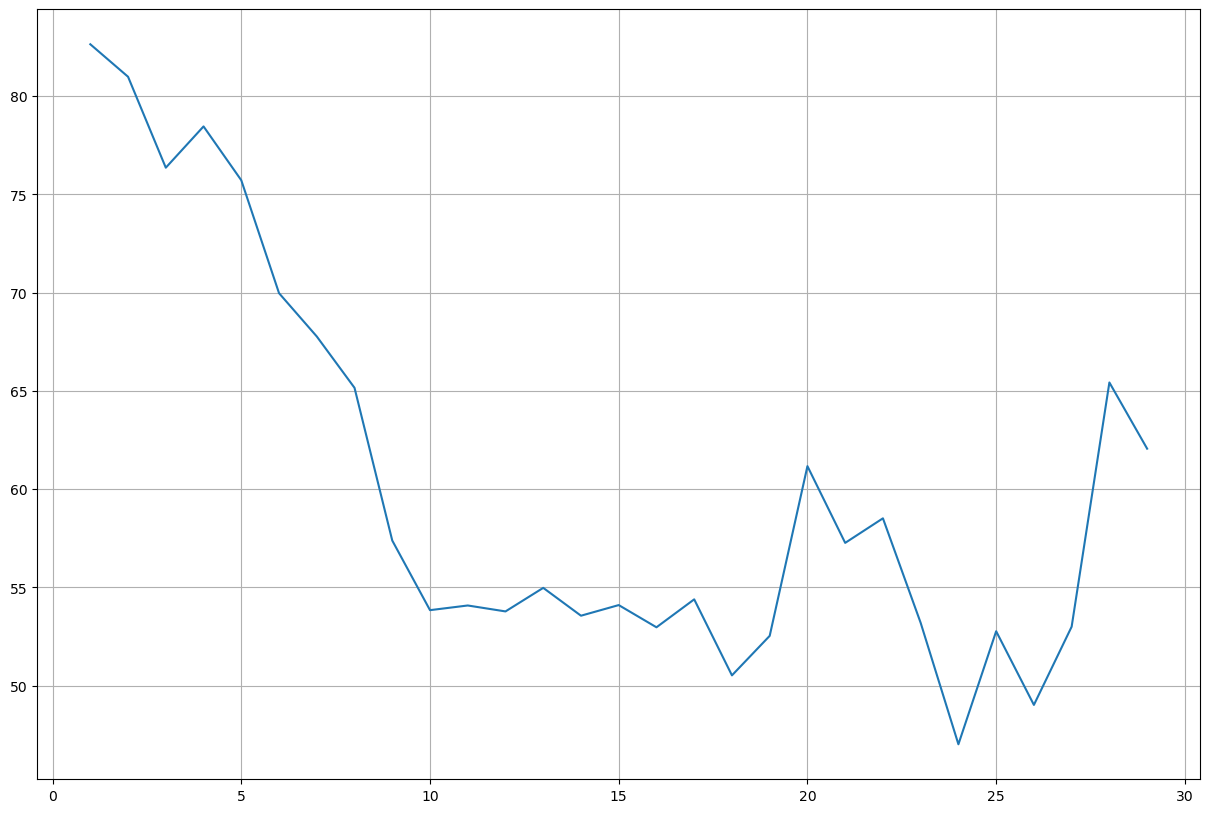

In [151]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(kilometer_total_area)
plt.show()

Дополнительный график распределения среднего общей площади показывает, что в аналогичном диапазоне удаленности от центра есть всплеск по значению общей площади жилья, поэтому резкий скачок цены можно связать со вводом в эксплуатацию нового жилого комплекса.

### Общий вывод

С представленными данными была проведена предварительная обработка, выявление и устранение дубликатов, артефактов, аномальных значений и пропусков.
Были выявлены критерии влияющие на стоимость жилья в городе Санкт-Петербурге и Ленинградской области.
Наиболее выраженное влияние на стоимость квадратного метра имеют:
- Общая площадь квартиры
- Жилая площадь и площадь кухни
- Количество комнат
- Удаленность от центра города
- Можно отметить значительно более высокую стоимость квартир продаваемых в декабре.
День и год публикации объявления не имеют существенного влияния на стоимость.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод